In [1]:
import sys
import math
import functools
from collections import namedtuple
import numpy as np
from uncertainties import ufloat, unumpy
import uncertainties
import scipy
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

sys.path.append("..")

%load_ext autoreload
%autoreload 1
from ntupleReaders.clue_ntuple_reader import ClueNtupleReader
from hists.parameters import beamEnergies, synchrotronBeamEnergiesMap
%aimport energy_resolution.sigma_over_e
from energy_resolution.sigma_over_e import SigmaOverEComputations, fitSigmaOverE, SigmaOverEPlotElement, plotSigmaOverMean, sigmaOverE_fitFunction, plotSCAsEllipse, EResolutionFitResult, SigmaMuResult, plotEllipse, plotFittedMean
from energy_resolution.hist_loader import HistLoader
#from fit import HistogramEstimates

/grid_mnt/data_cms_upgrade/cuisset/conda/envs/clustering-analysis/lib/python3.11/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
levels = ["rechits", "clue", "clue3d"]
levelLabelMap = {"rechits":"Rechits", "clue":"CLUE", "clue3d":"CLUE3D", "paper" : "JINST paper"}
levelColorMap = {"rechits":"tab:blue", "clue":"tab:orange", "clue3d":"tab:green", "paper":"tab:gray"}
fitFunction = "truncatedGaussian" # cruijff truncatedGaussian

In [3]:
reader_data = ClueNtupleReader("v43", "cmssw", "data") 
reader_sim = ClueNtupleReader("v43", "cmssw", "sim_proton_v46_patchMIP") 
comp_data = SigmaOverEComputations(sigmaWindow=(1, 2.5), fitFunction=fitFunction)
res_data = {level : comp_data.compute({beamEnergy : HistLoader(reader_data.histStore).getProjected(reader_data.datatype, beamEnergy, level) for beamEnergy in beamEnergies}, multiprocess=True)
            for level in levels}
comp_sim = SigmaOverEComputations(sigmaWindow=(1, 2.5), fitFunction=fitFunction)
res_sim = {level : comp_sim.compute({beamEnergy : HistLoader(reader_sim.histStore).getProjected(reader_sim.datatype, beamEnergy, level) for beamEnergy in beamEnergies}, multiprocess=True)
            for level in levels}

In [4]:
res = comp_data.singleFit(comp_data.h_per_energy[100])
res

Iterative fitting - 97 GeV:   0%|          | 0/5 [00:00<?, ?it/s]

SigmaMuResult(mu=97.06599534791854+/-0.02710065400097513, sigma=2.3095879314722345+/-0.022178505098387067, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7f0483c36a90>, fitQuality='good')

In [5]:
for beamEnergy in beamEnergies:
    #print(comp_data.results[beamEnergy].fitResult.edm)
    fitRes = res_data["rechits"][beamEnergy].fitResult
    print(f"Fit at {beamEnergy} GeV")
    for param in fitRes.params:
        print(f"{param} = {fitRes.params[param]['value']} +- {math.sqrt(fitRes._covariance_dict['minuit_hesse'][param, param])}")

Fit at 20 GeV
mu = 19.640632106398947 +- 0.012204916139974412
sigma = 0.9521271960632918 +- 0.010711134762357842
Fit at 30 GeV
mu = 29.50692219713345 +- 0.014684436679356642
sigma = 1.1669665613348805 +- 0.012435371157808815
Fit at 50 GeV
mu = 49.854996583464654 +- 0.012005850740420862
sigma = 1.5730782085911548 +- 0.010021823444847783
Fit at 80 GeV
mu = 80.34005533191957 +- 0.017990144675101346
sigma = 2.0450047868614654 +- 0.014619607609036103
Fit at 100 GeV
mu = 100.75503370013011 +- 0.027200285036519337
sigma = 2.3583637448692882 +- 0.022024978346569735
Fit at 120 GeV
mu = 121.21016043664548 +- 0.03165545092701157
sigma = 2.4921605908584477 +- 0.02558988662536463
Fit at 150 GeV
mu = 151.03343240199789 +- 0.030698124526623596
sigma = 2.822720400494277 +- 0.025126694309294238
Fit at 200 GeV
mu = 199.88574098531834 +- 0.04751212624396393
sigma = 3.1979301287059267 +- 0.0390844190771002
Fit at 250 GeV
mu = 245.88314595624254 +- 0.056777066158450386
sigma = 3.6644530185690933 +- 0.04554

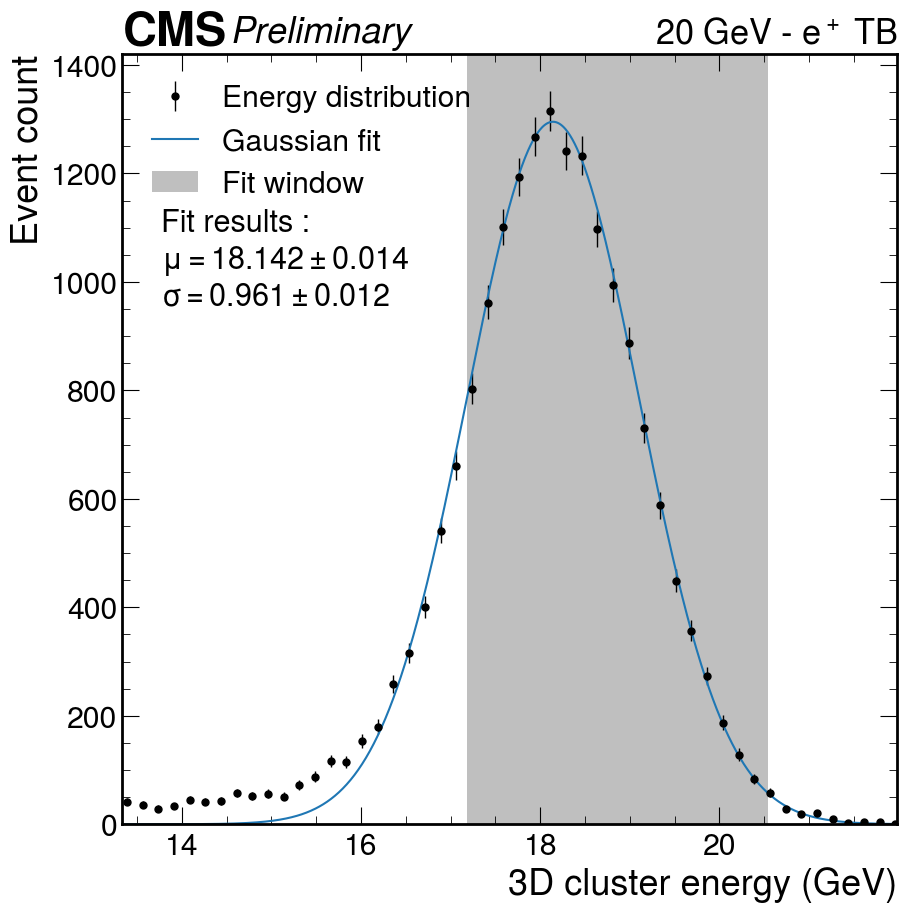

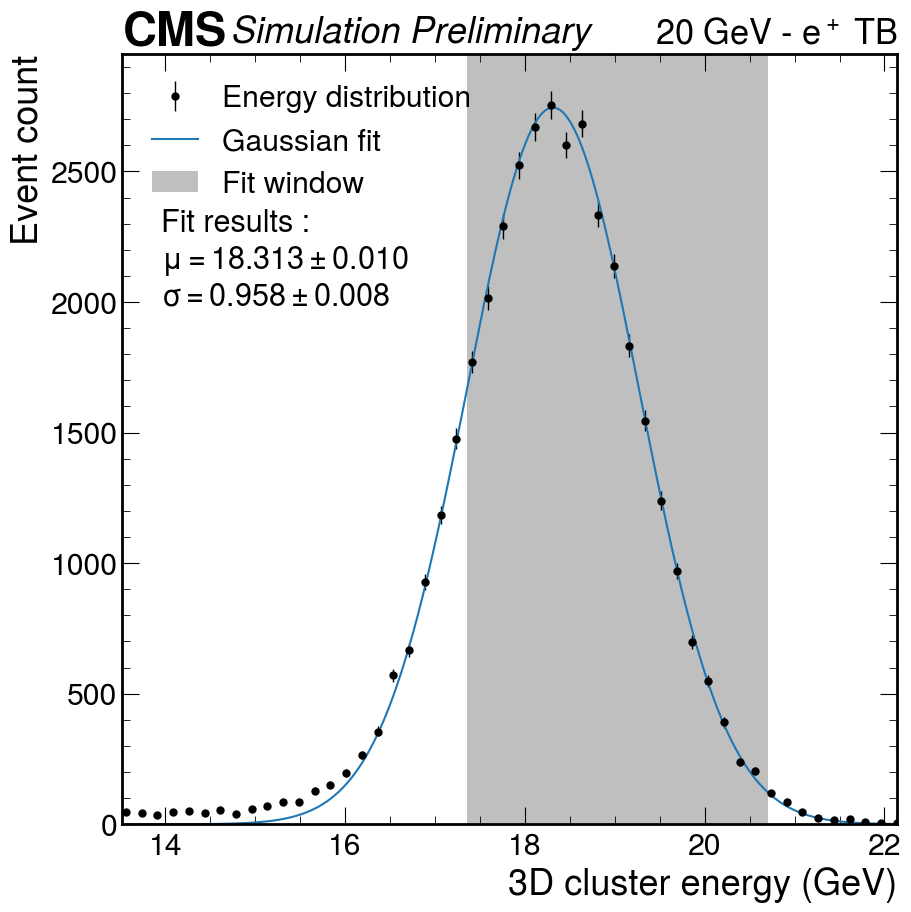

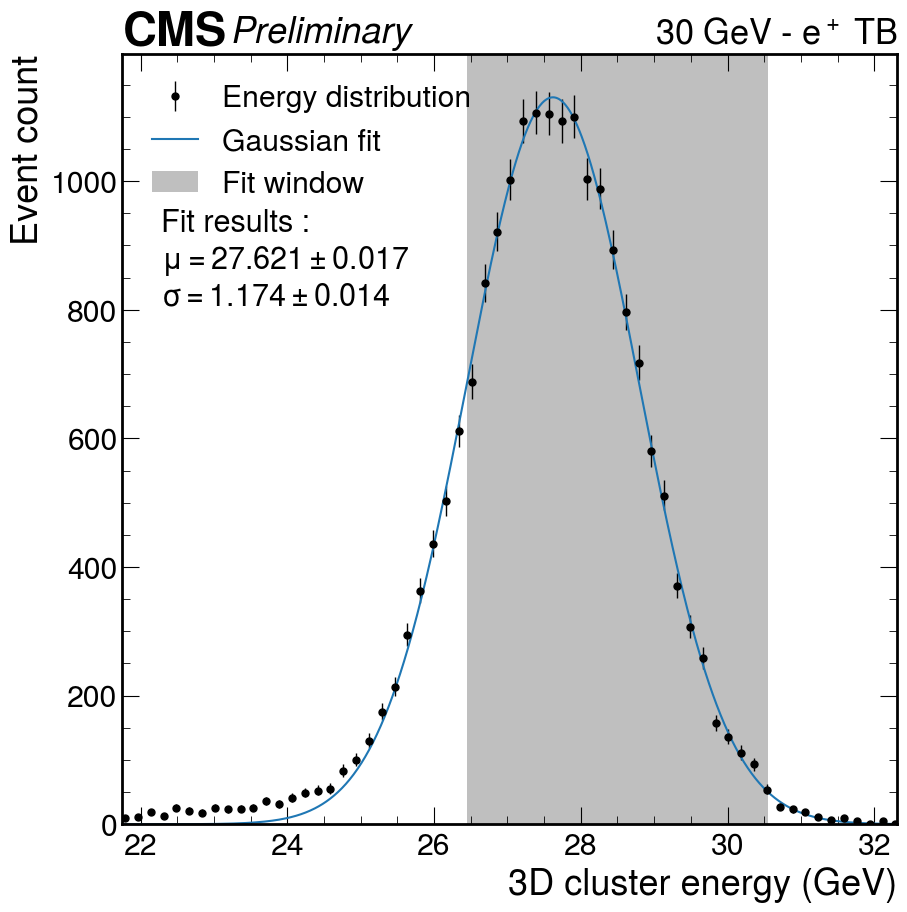

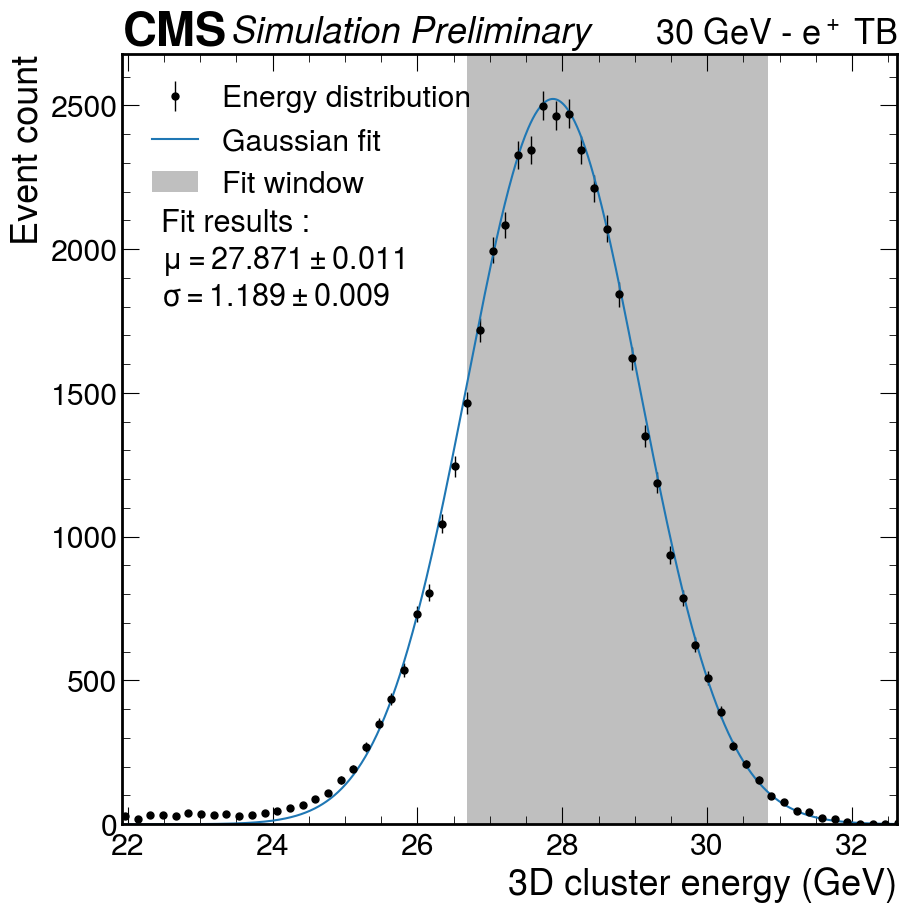

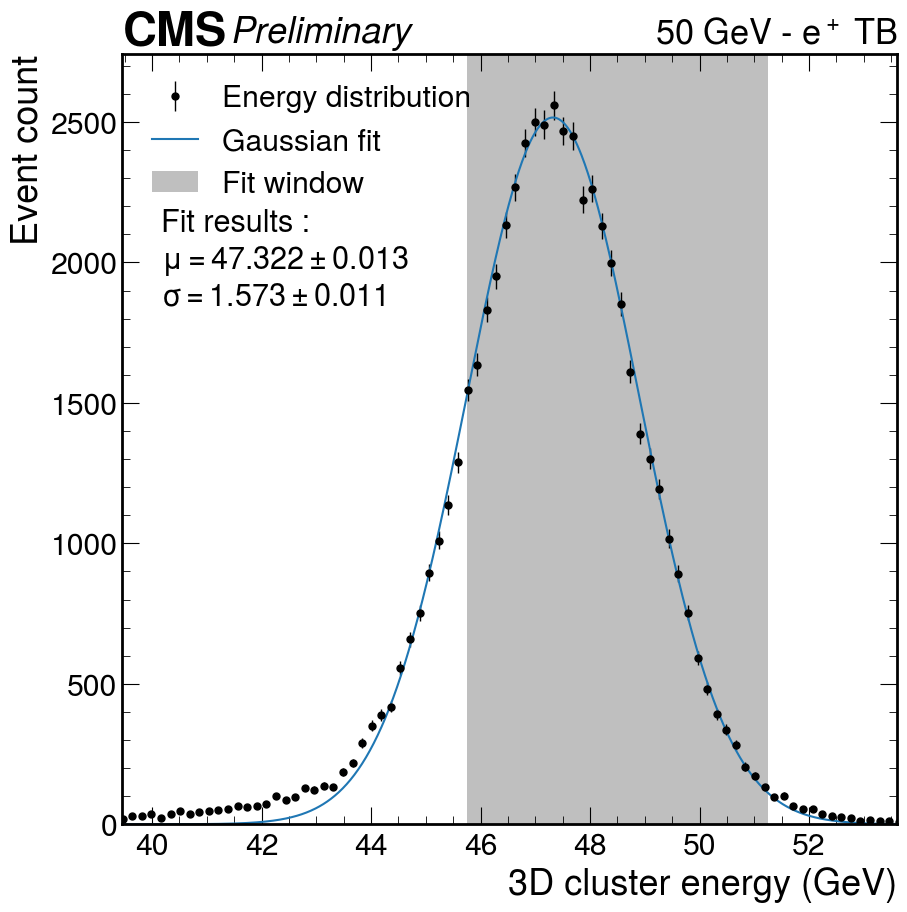

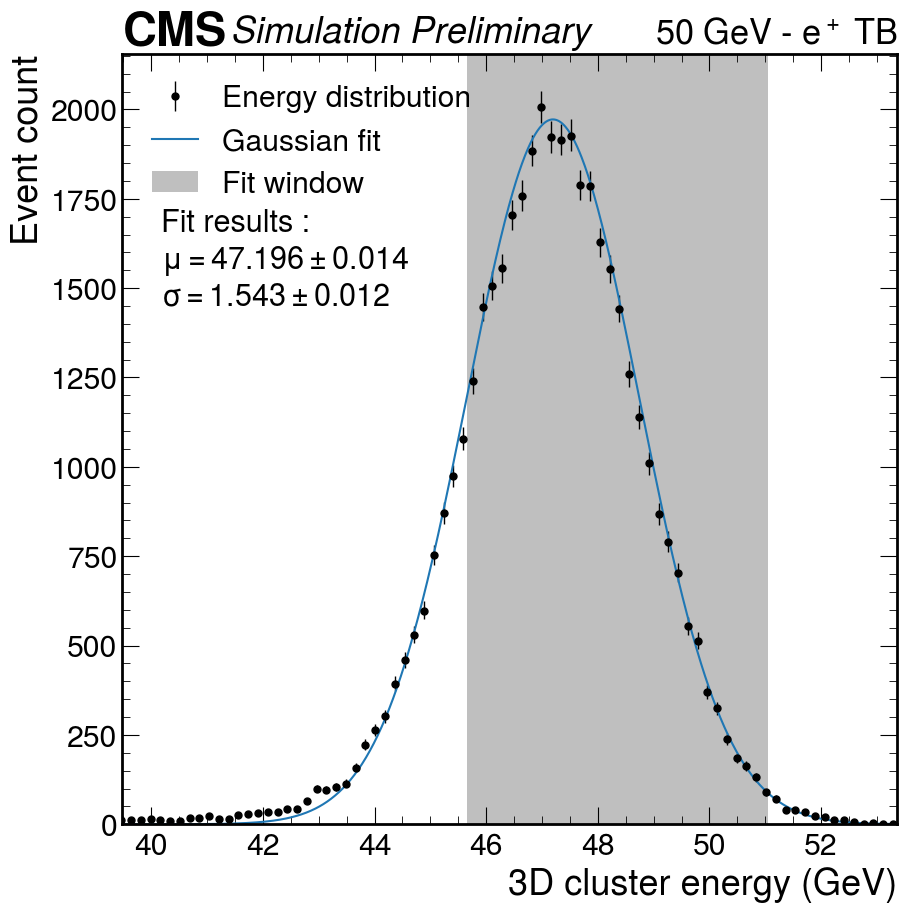

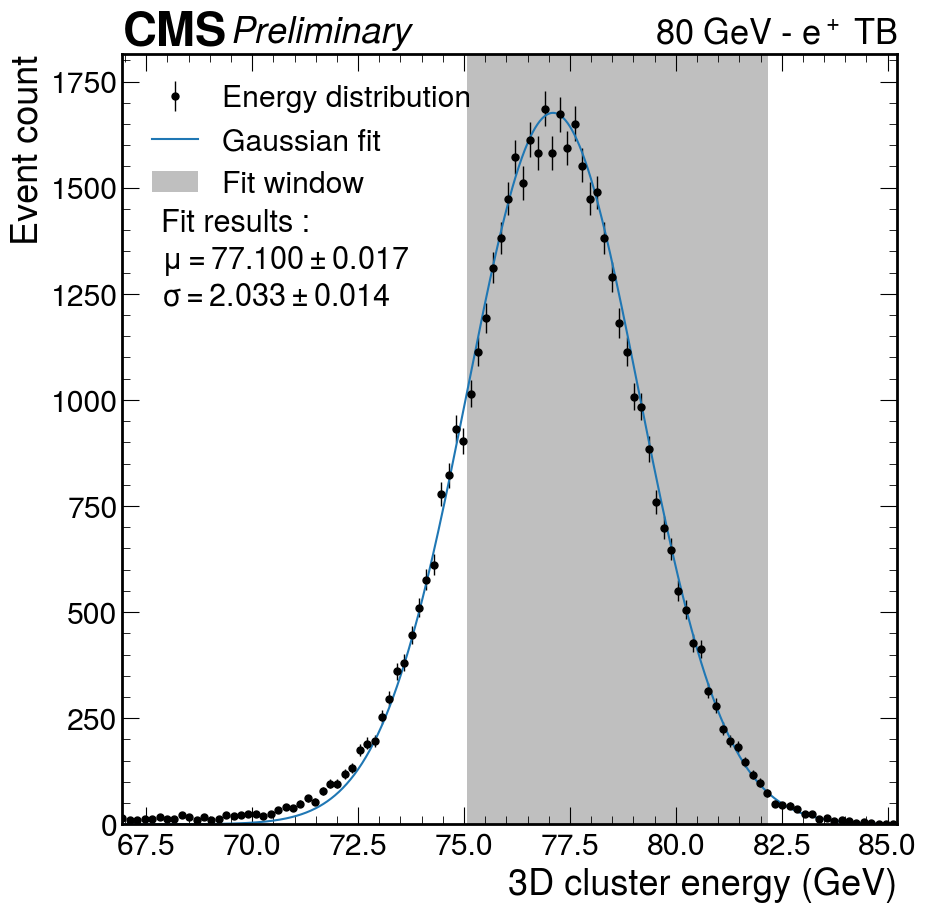

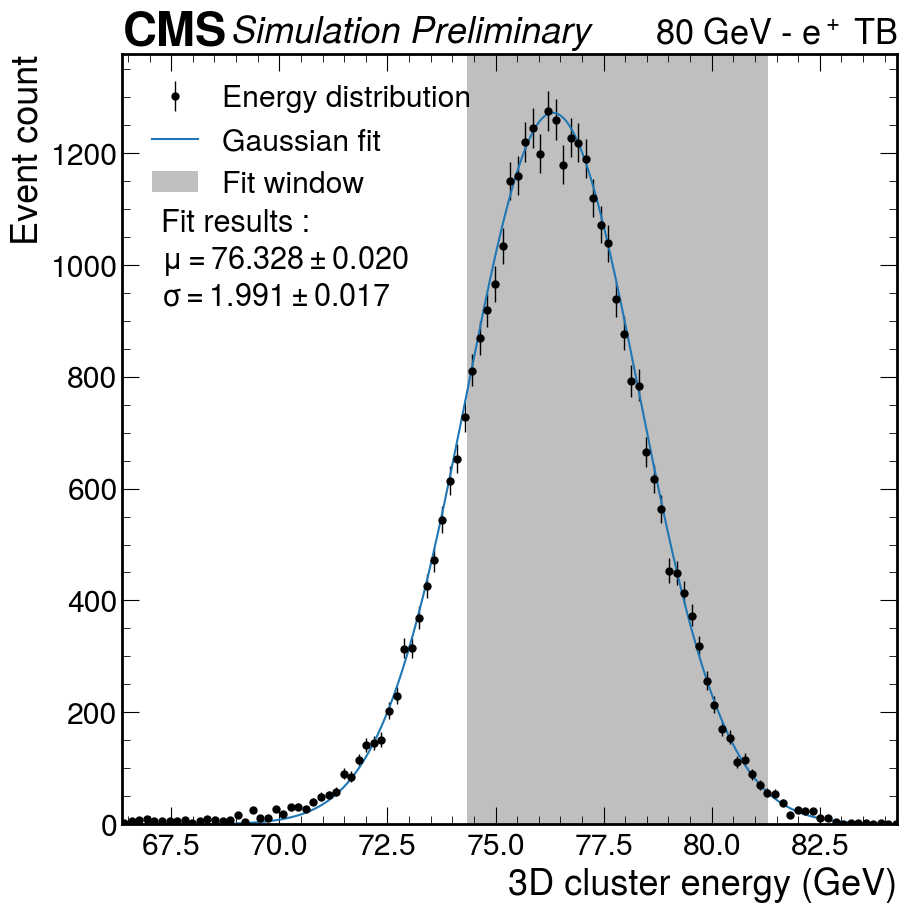

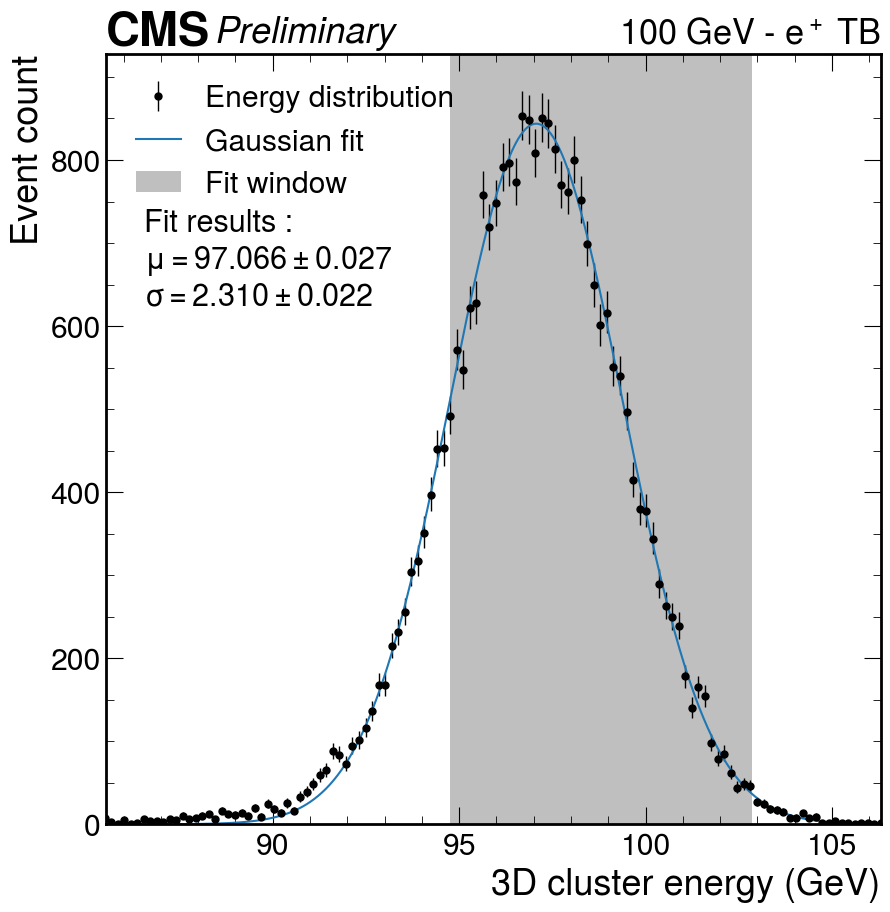

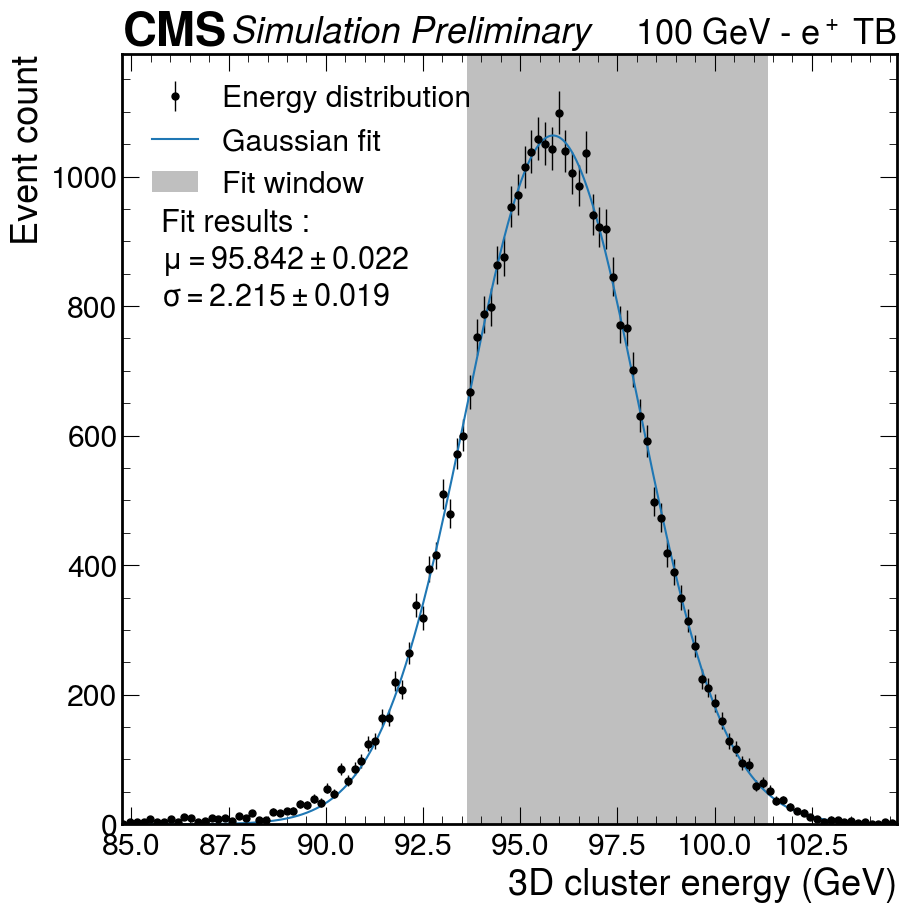

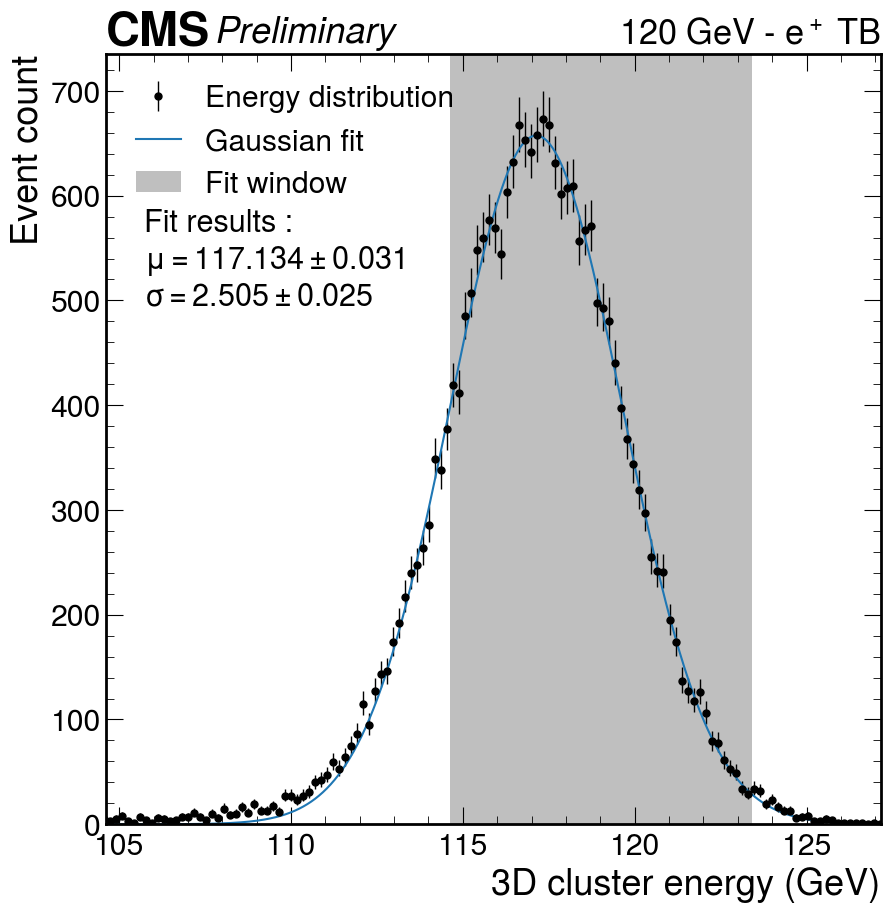

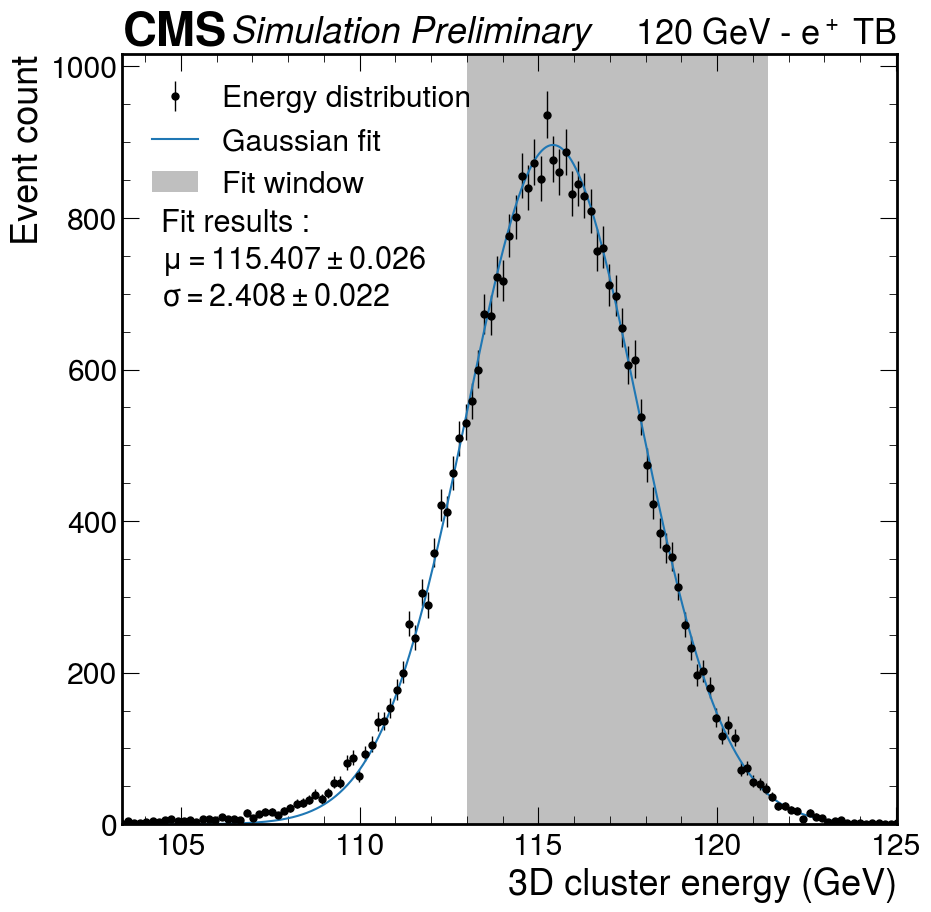

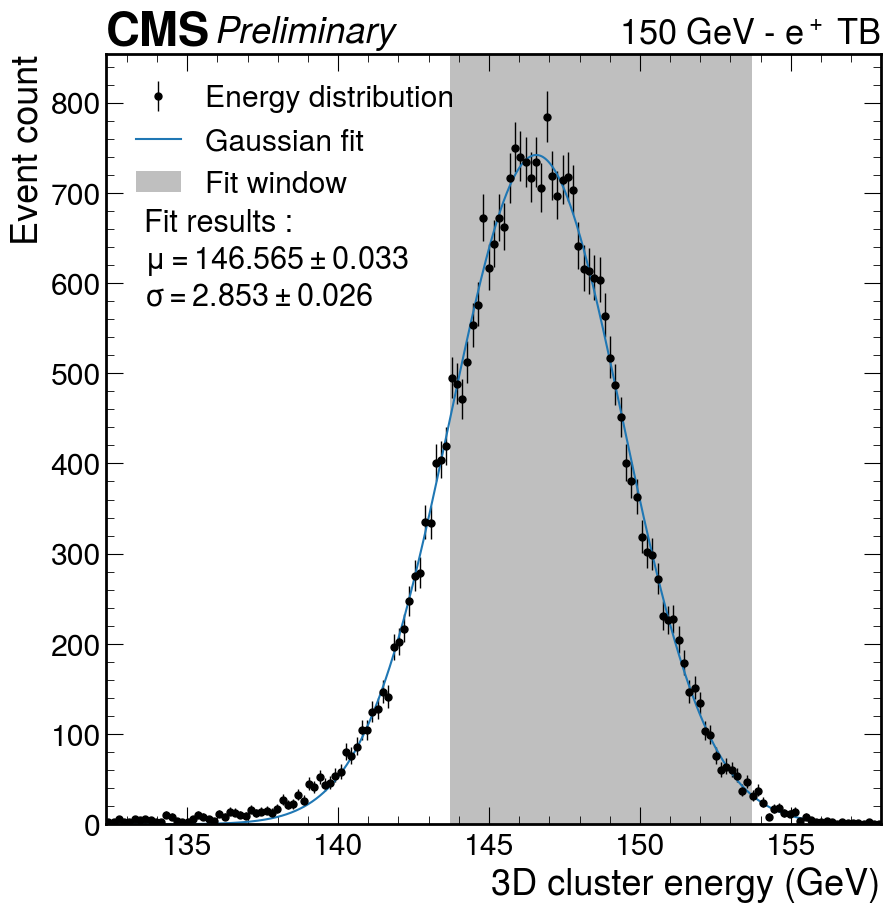

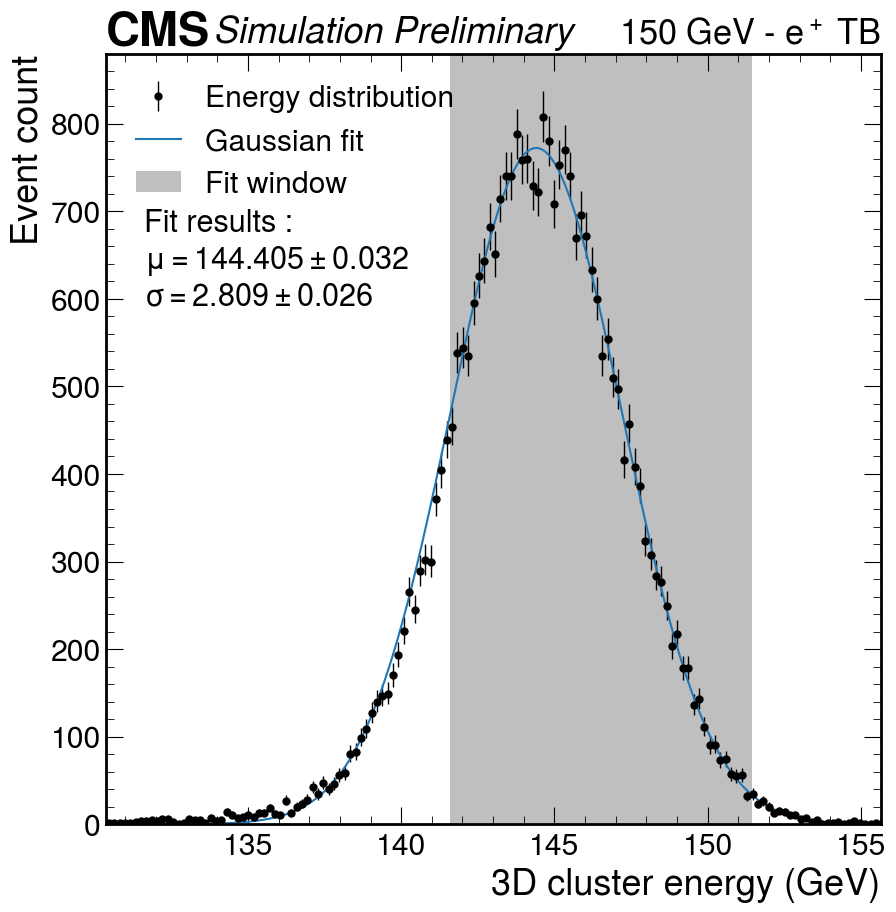

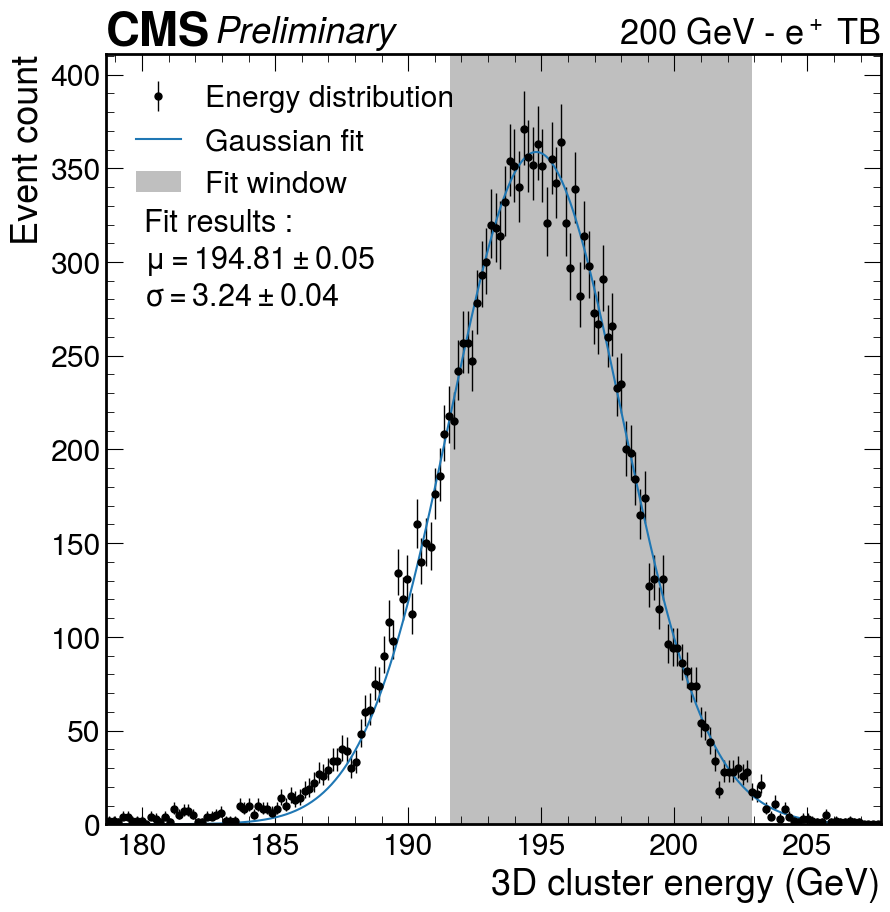

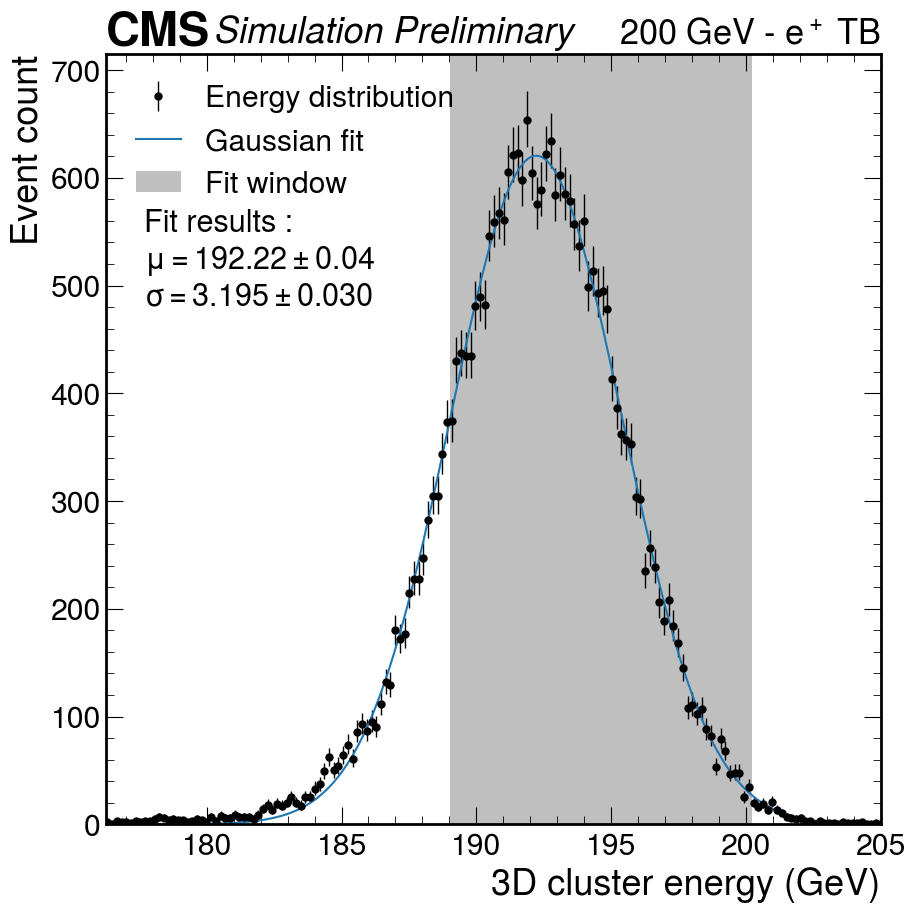

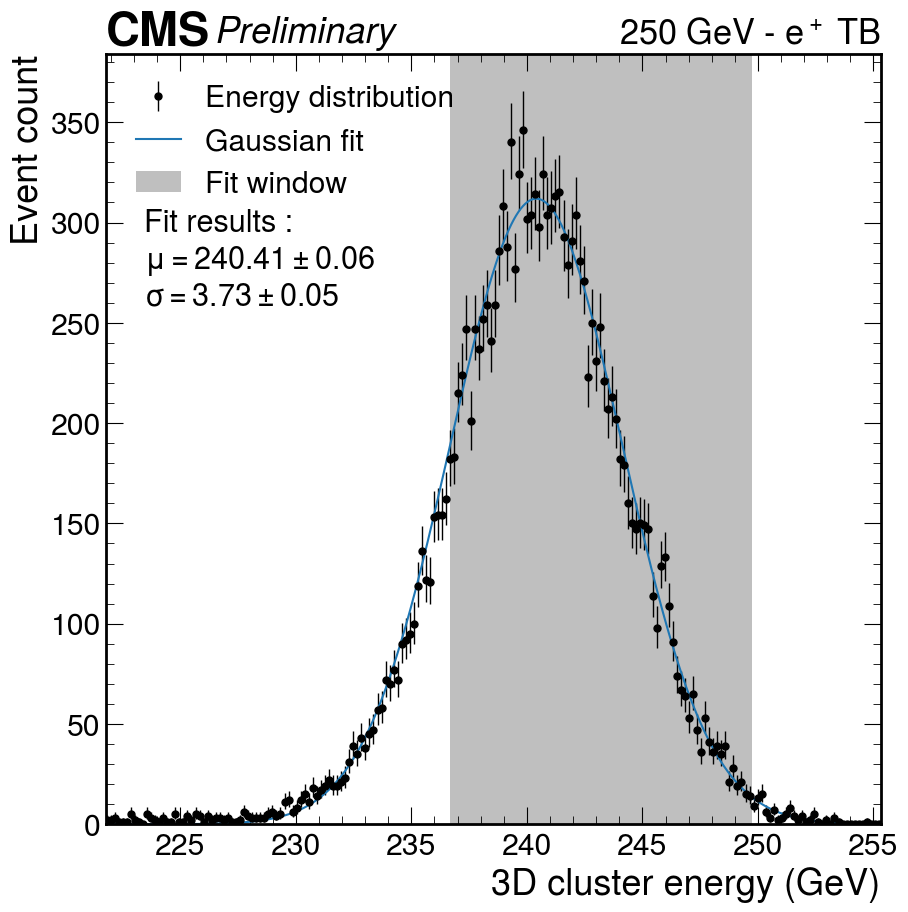

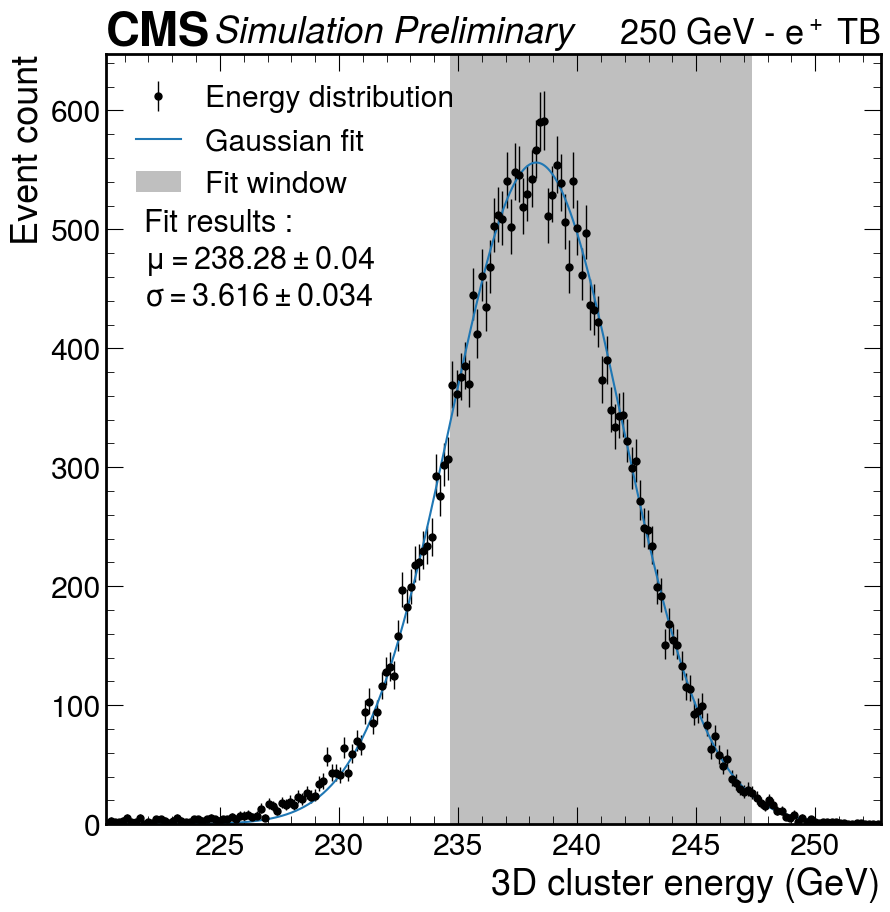

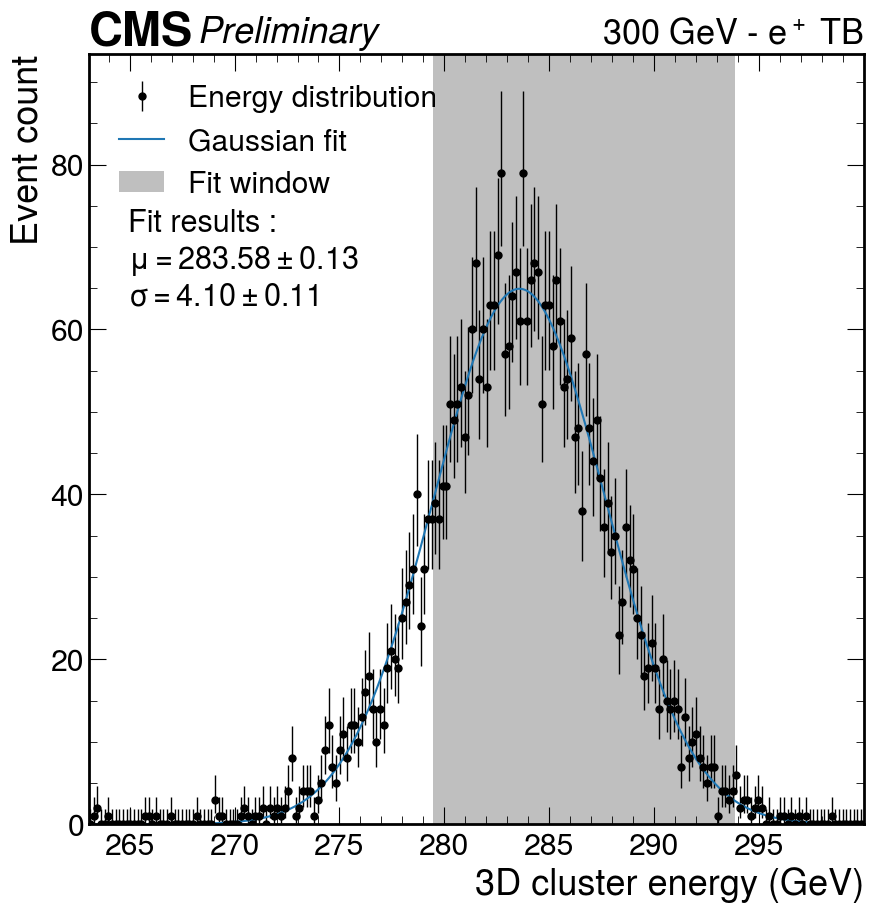

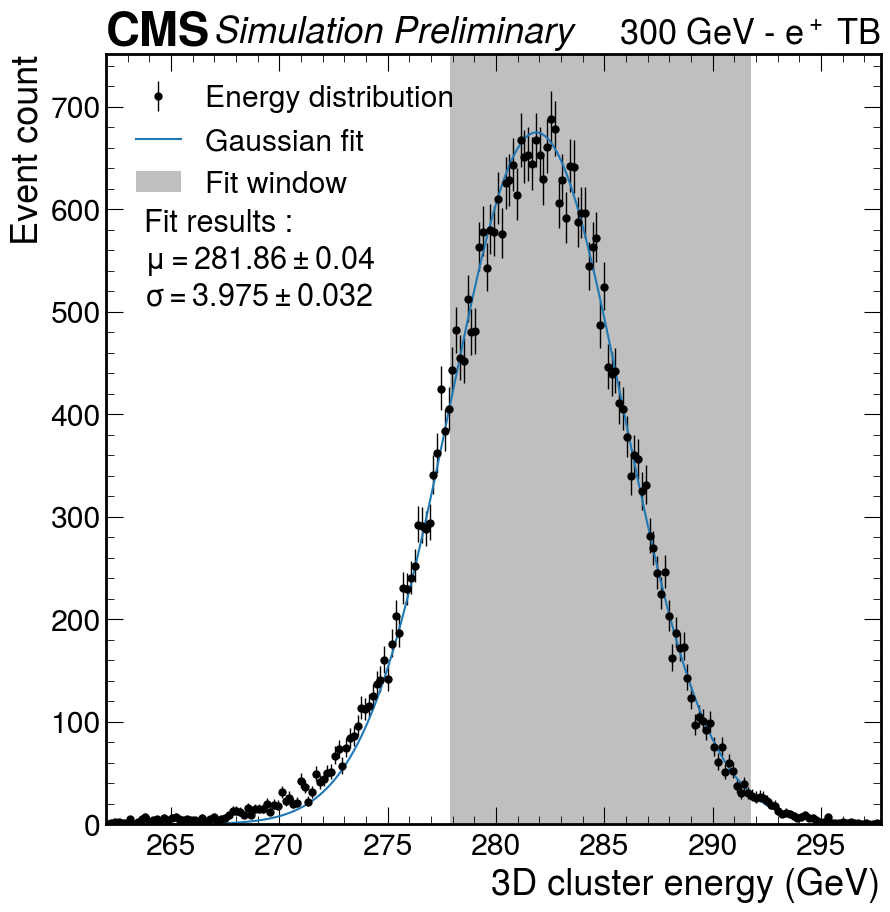

In [4]:
for beamEnergy in beamEnergies:
    comp_data.plotFitResult(beamEnergy)
    plt.savefig(f"plots/energyFits/{beamEnergy}-data-{fitFunction}.pdf", bbox_inches="tight")
    comp_sim.plotFitResult(beamEnergy, sim=True)
    plt.savefig(f"plots/energyFits/{beamEnergy}-sim-{fitFunction}.pdf", bbox_inches="tight")

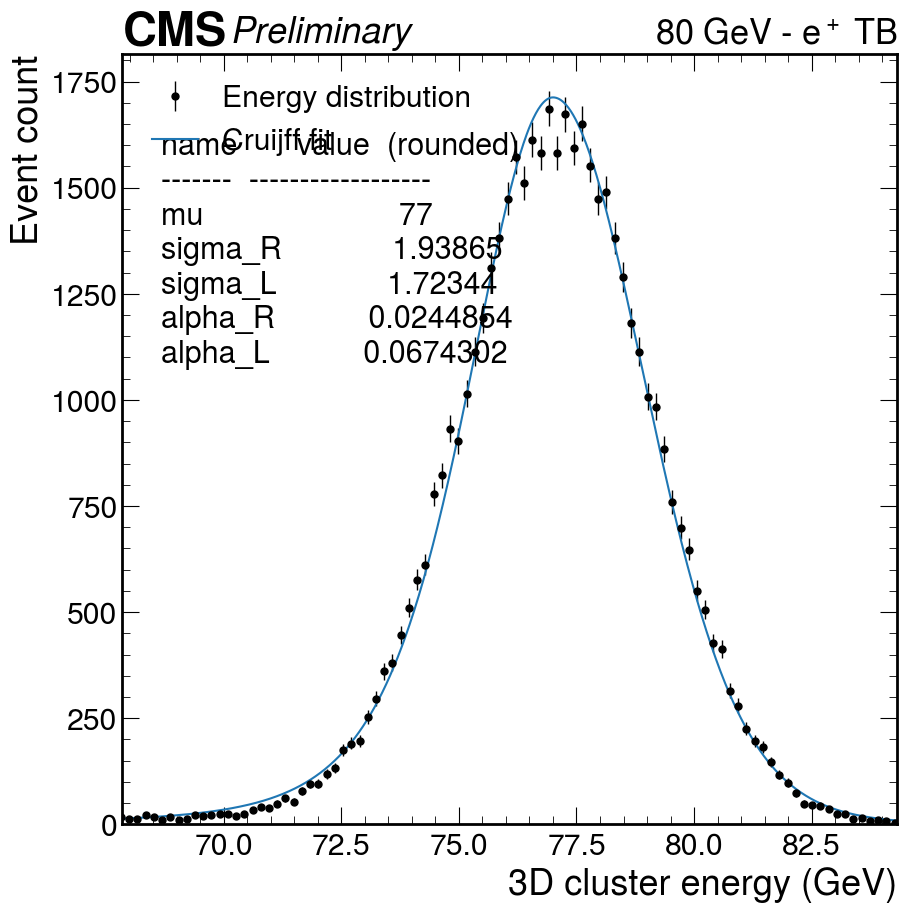

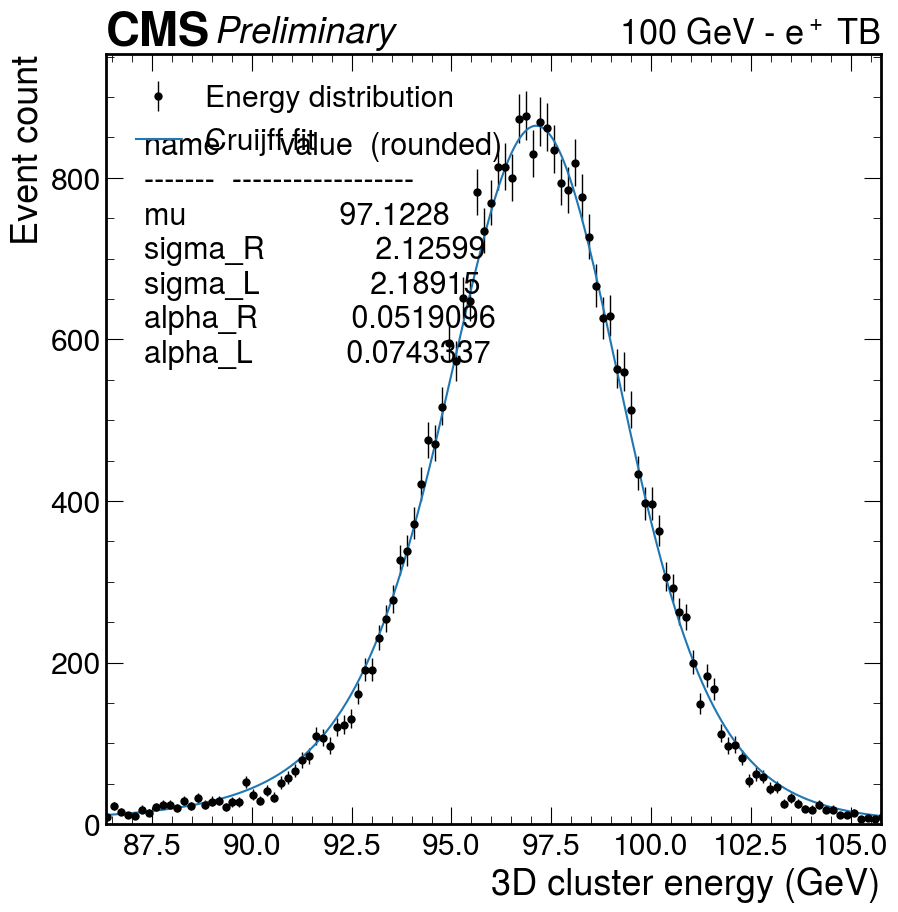

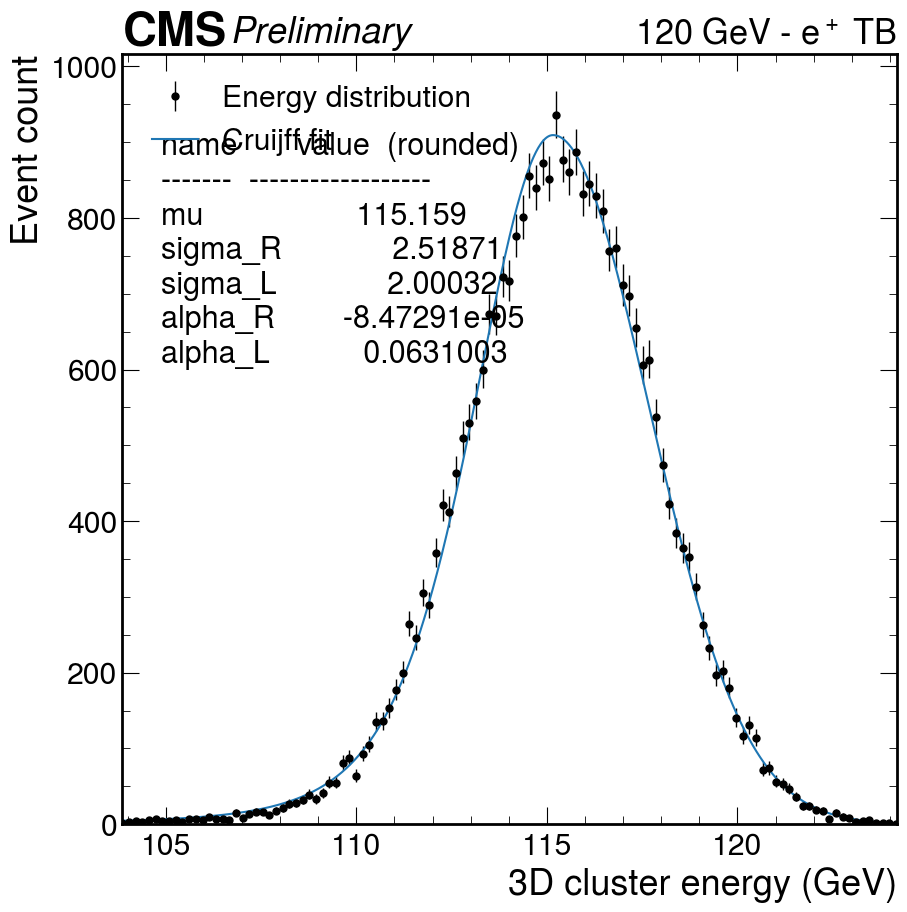

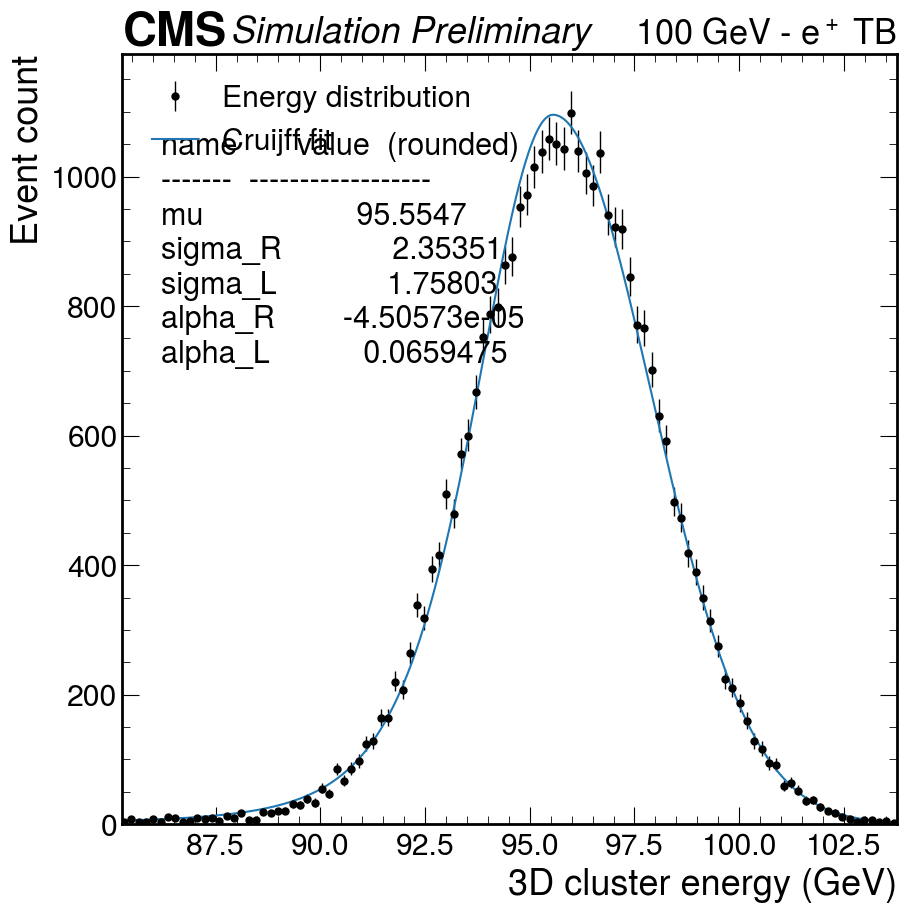

In [4]:
comp_data.plotFitResult(80)
comp_data.plotFitResult(100)
comp_sim.plotFitResult(120)
comp_sim.plotFitResult(100, sim=True)
None

In [5]:
res_data["rechits"][20]

SigmaMuResult(mu=19.640632106398947+/-0.012204916139974412, sigma=0.9521271960632918+/-0.010711134762357839, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7f048919ca50>, fitQuality='good')

In [6]:
eRes_fit_data = {level : fitSigmaOverE(res) for level, res in res_data.items()}
eRes_fit_sim = {level : fitSigmaOverE(res) for level, res in res_sim.items()}

# From JINST paper (https://arxiv.org/abs/2111.06855), table 3, dEdx method
paperResolution_data = EResolutionFitResult(S=uncertainties.ufloat(22, 0.3)/100, C=uncertainties.ufloat(0.53, 0.09)/100)
paperResolution_sim = EResolutionFitResult(S=uncertainties.ufloat(21.3, 0.3)/100, C=uncertainties.ufloat(0.55, 0.07)/100)

In [9]:
def printRes(res):
    return f"S = {res.S*100:.1f}" " & " f"C = {res.C*100:.2f}"
printRes(eRes_fit_data["clue3d"])
printRes(eRes_fit_sim["clue3d"])

'S = 23.1+/-0.1 & C = 0.32+/-0.05'

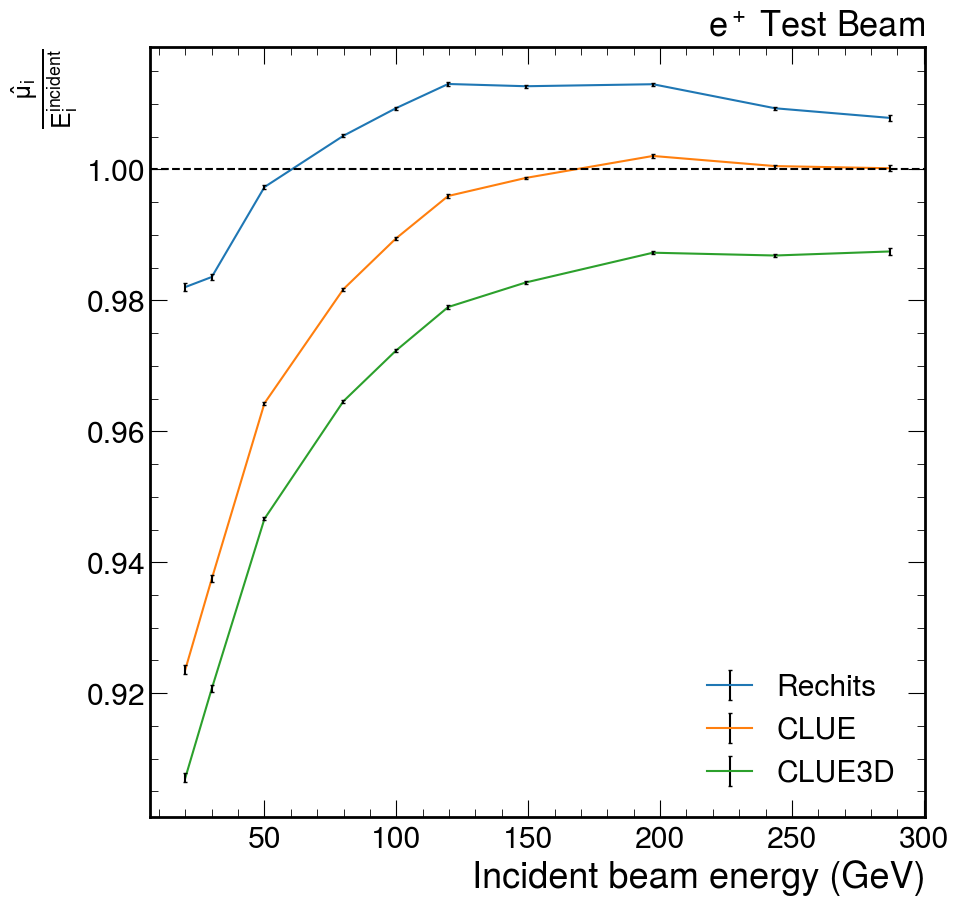

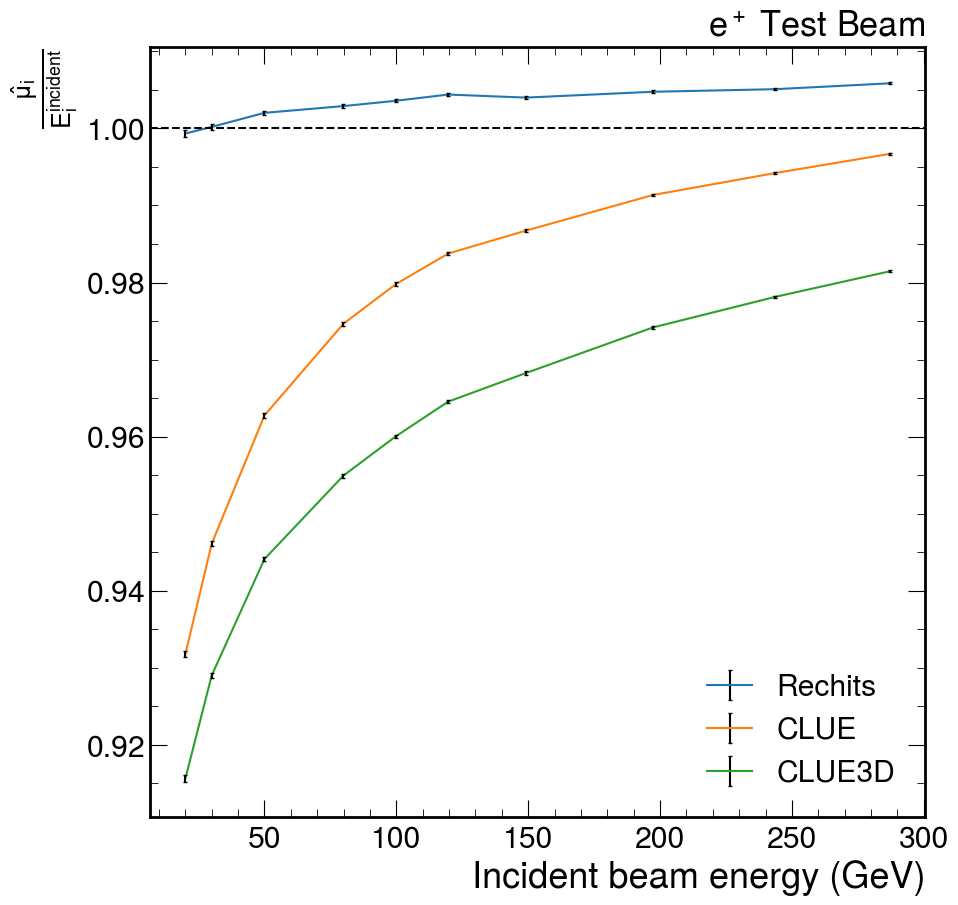

In [6]:
plotFittedMean(res_data, errors=True, levelLabelMap=levelLabelMap, normByRechits=False)
#plt.savefig("plots/mu-over-beam.pdf", bbox_inches="tight")
plotFittedMean(res_sim, errors=True, levelLabelMap=levelLabelMap, normByRechits=False)
None

### mean over rechits - DPS plot

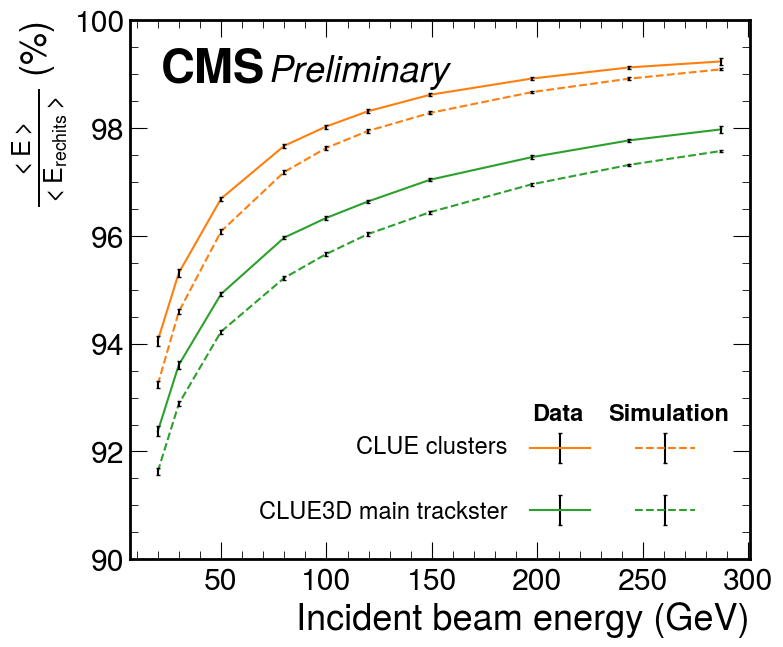

In [7]:
fig, ax = plt.subplots(figsize=(8, 7))
#plotFittedMean(res_data, errors=True, levelLabelMap=levelLabelMap, normByRechits=True, ax=ax)
#plotFittedMean(res_sim, errors=True, levelLabelMap=levelLabelMap, normByRechits=True, ax=ax)

xValues = [synchrotronBeamEnergiesMap[beamEnergy] for beamEnergy in res_data["rechits"]]

common_kwargs = dict(
    x=xValues,  capsize=1.5, ecolor="black", elinewidth=1.5, barsabove=True
)

plot_dict_data = {level : np.array([level_dict[beamEnergy].mu / res_data["rechits"][beamEnergy].mu for beamEnergy in level_dict]) 
    for level, level_dict in res_data.items()}
plot_dict_sim = {level : np.array([level_dict[beamEnergy].mu / res_sim["rechits"][beamEnergy].mu for beamEnergy in level_dict]) 
    for level, level_dict in res_sim.items()}
ax.errorbar(y=unumpy.nominal_values(plot_dict_data["clue"]), yerr=unumpy.std_devs(plot_dict_data["clue"]), **common_kwargs, color="tab:orange", label="All CLUE clusters (data)", fmt='-',)
ax.errorbar(y=unumpy.nominal_values(plot_dict_data["clue3d"]), yerr=unumpy.std_devs(plot_dict_data["clue3d"]), **common_kwargs, color="tab:green", label="CLUE3D (data)", fmt='-')

ax.errorbar(y=unumpy.nominal_values(plot_dict_sim["clue"]), yerr=unumpy.std_devs(plot_dict_sim["clue"]), **common_kwargs, color="tab:orange", label="CLUE (simulation)", fmt='--')
ax.errorbar(y=unumpy.nominal_values(plot_dict_sim["clue3d"]), yerr=unumpy.std_devs(plot_dict_sim["clue3d"]), **common_kwargs, color="tab:green", label="CLUE3D (simulation)", fmt='--')


ax.set_ylabel("$\\frac{<E>}{<E_{rechits}>}$ (%)")
ax.set_xlabel("Incident beam energy (GeV)")
ax.set_ylim(0.9, 1)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, symbol=None, decimals=0))
ax.axhline(y=1, linestyle="--", color="black")
hep.cms.text("Preliminary", ax=ax, loc=1)
# ax.text(
#     s="$e^+$ Test Beam",
#     x=0.95, y=0.91, 
#     transform=ax.transAxes,
#     ha="right", va="center",
#     fontsize=matplotlib.rcParams["font.size"] * 0.9,
#     fontweight="normal",
#     fontname="TeX Gyre Heros",
# )
yBottom = -0.02
legendKw = dict(handleheight=2, handlelength=2)
leg1 = plt.legend(handles=plt.gca().get_legend_handles_labels()[0][:2], labels=[None]*3, loc="lower right", bbox_to_anchor=(0.83, yBottom), **legendKw)
plt.gca().add_artist(leg1)
plt.legend(handles=plt.gca().get_legend_handles_labels()[0][2:], labels=[None]*3, loc="lower right", bbox_to_anchor=(1.0, yBottom), **legendKw)
textKw = dict(transform=plt.gca().transAxes, fontsize=17, ha="right", va="top")
textyBottom = yBottom+0.13
textVertPad = 0.12
plt.text(x=0.61, y=textyBottom+textVertPad, s="CLUE clusters", **textKw)
plt.text(x=0.61, y=textyBottom, s="CLUE3D main trackster", **textKw)
plt.text(x=0.69, y=yBottom+0.31, ha="center", va="top", fontsize=17, transform=plt.gca().transAxes, s="Data", weight="bold")
plt.text(x=0.87, y=yBottom+0.31, ha="center", va="top", fontsize=17, transform=plt.gca().transAxes, s="Simulation", weight="bold")

plt.savefig("plots/mu-over-rechits.pdf", bbox_inches="tight")

### mean over rechits - DPS plot - with ratio plot

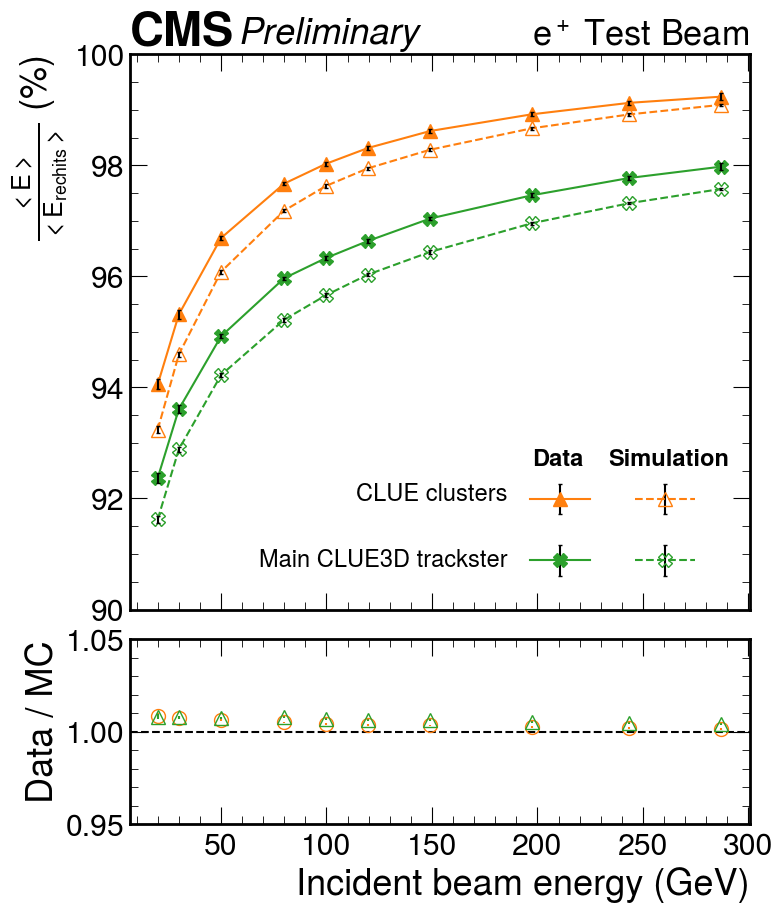

In [5]:
fig = plt.figure(figsize=(8, 10))
grid = fig.add_gridspec(2, 1, hspace=0.08, height_ratios=[3, 1])

ax = fig.add_subplot(grid[0])
subplot_ax = fig.add_subplot(grid[1], sharex=ax)
plt.setp(ax.get_xticklabels(), visible=False)
#plotFittedMean(res_data, errors=True, levelLabelMap=levelLabelMap, normByRechits=True, ax=ax)
#plotFittedMean(res_sim, errors=True, levelLabelMap=levelLabelMap, normByRechits=True, ax=ax)

xValues = [synchrotronBeamEnergiesMap[beamEnergy] for beamEnergy in res_data["rechits"]]

common_kwargs = dict(
    x=xValues,  capsize=1.5, ecolor="black", elinewidth=1.5, barsabove=True, markersize=10
)

plot_dict_data = {level : np.array([level_dict[beamEnergy].mu / res_data["rechits"][beamEnergy].mu for beamEnergy in level_dict]) 
    for level, level_dict in res_data.items()}
plot_dict_sim = {level : np.array([level_dict[beamEnergy].mu / res_sim["rechits"][beamEnergy].mu for beamEnergy in level_dict]) 
    for level, level_dict in res_sim.items()}
ax.errorbar(y=unumpy.nominal_values(plot_dict_data["clue"]), yerr=unumpy.std_devs(plot_dict_data["clue"]), **common_kwargs, 
        color="tab:orange", label="All CLUE clusters (data)", fmt='^-',)
ax.errorbar(y=unumpy.nominal_values(plot_dict_data["clue3d"]), yerr=unumpy.std_devs(plot_dict_data["clue3d"]), **common_kwargs,
        color="tab:green", label="CLUE3D (data)", fmt='X-',)

ax.errorbar(y=unumpy.nominal_values(plot_dict_sim["clue"]), yerr=unumpy.std_devs(plot_dict_sim["clue"]), **common_kwargs,
        color="tab:orange", label="CLUE (simulation)", fmt='^--', fillstyle="none")
ax.errorbar(y=unumpy.nominal_values(plot_dict_sim["clue3d"]), yerr=unumpy.std_devs(plot_dict_sim["clue3d"]), **common_kwargs,
        color="tab:green", label="CLUE3D (simulation)", fmt='X--', fillstyle="none")


ax.set_ylabel("$\\frac{<E>}{<E_{rechits}>}$ (%)")
subplot_ax.set_xlabel("Incident beam energy (GeV)")
ax.set_ylim(0.9, 1)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, symbol=None, decimals=0))
ax.axhline(y=1, linestyle="--", color="black")
hep.cms.text("Preliminary", ax=ax, loc=0)
hep.cms.lumitext("$e^+$ Test Beam", ax=ax)
# ax.text(
#     s="$e^+$ Test Beam",
#     x=0.95, y=0.91, 
#     transform=ax.transAxes,
#     ha="right", va="center",
#     fontsize=matplotlib.rcParams["font.size"] * 0.9,
#     fontweight="normal",
#     fontname="TeX Gyre Heros",
# )
yBottom = -0.02
legendKw = dict(handleheight=2, handlelength=2)
leg1 = ax.legend(handles=ax.get_legend_handles_labels()[0][:2], labels=[None]*3, loc="lower right", bbox_to_anchor=(0.83, yBottom), **legendKw)
ax.add_artist(leg1)
ax.legend(handles=ax.get_legend_handles_labels()[0][2:], labels=[None]*3, loc="lower right", bbox_to_anchor=(1.0, yBottom), **legendKw)
textKw = dict(transform=ax.transAxes, fontsize=17, ha="right", va="top")
textyBottom = yBottom+0.13
textVertPad = 0.12
ax.text(x=0.61, y=textyBottom+textVertPad, s="CLUE clusters", **textKw)
ax.text(x=0.61, y=textyBottom, s="Main CLUE3D trackster", **textKw)
ax.text(x=0.69, y=yBottom+0.31, ha="center", va="top", fontsize=17, transform=ax.transAxes, s="Data", weight="bold")
ax.text(x=0.87, y=yBottom+0.31, ha="center", va="top", fontsize=17, transform=ax.transAxes, s="Simulation", weight="bold")


subplot_ax.axhline(1, color="black", linestyle="--")
common_kwargs = dict(
    x=xValues, markerfacecolor="none", markersize=10
)
subplot_ax.errorbar(**common_kwargs, y=unumpy.nominal_values(plot_dict_data["clue"]/plot_dict_sim["clue"]), yerr=unumpy.std_devs(plot_dict_data["clue"]/plot_dict_sim["clue"]), 
                    color="tab:orange", fmt="o")
subplot_ax.errorbar(**common_kwargs, y=unumpy.nominal_values(plot_dict_data["clue3d"]/plot_dict_sim["clue3d"]), yerr=unumpy.std_devs(plot_dict_data["clue3d"]/plot_dict_sim["clue3d"]),
                    color="tab:green", fmt="^")

subplot_ax.set_ylim(0.95, 1.05)
subplot_ax.set_ylabel("Data / MC")
plt.savefig("plots/mu-over-rechits-ratio.pdf", bbox_inches="tight")

In [9]:
def makeDataPoints(res:dict[int, SigmaMuResult]):
    return {beamEnergy : result.sigma / result.mu for beamEnergy, result in res.items()}

def plotFctOfE(res, eRes_fit, showClue=True, **kwargs):
    plotElements = [
        SigmaOverEPlotElement("Rechits", fitResult=eRes_fit["rechits"], fitFunction=sigmaOverE_fitFunction, 
            dataPoints=makeDataPoints(res["rechits"]), color=levelColorMap["rechits"]),
        SigmaOverEPlotElement("CLUE3D", fitResult=eRes_fit["clue3d"], fitFunction=sigmaOverE_fitFunction, 
            dataPoints=makeDataPoints(res["clue3d"]), color=levelColorMap["clue3d"]),
    ]
    if showClue:
        plotElements.insert(1, SigmaOverEPlotElement("CLUE", fitResult=eRes_fit["clue"], fitFunction=sigmaOverE_fitFunction, 
            dataPoints=makeDataPoints(res["clue"]), color=levelColorMap["clue"]))
    plotSigmaOverMean(plotElements=plotElements, **kwargs)

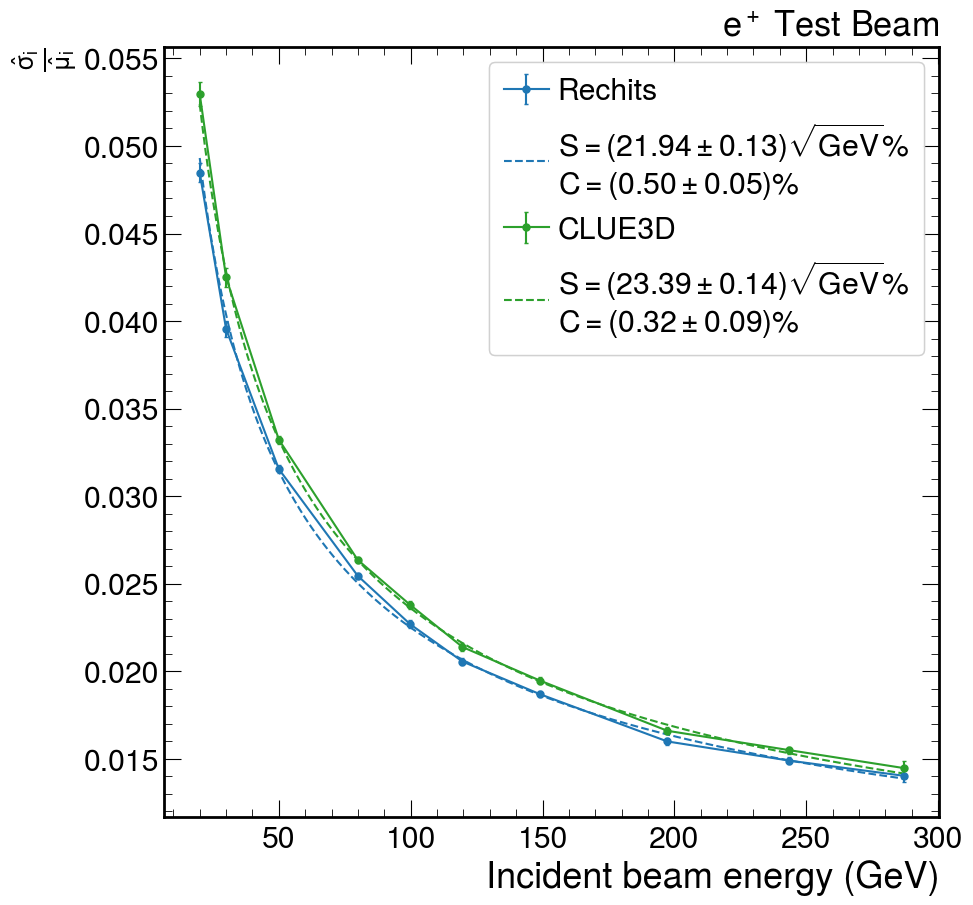

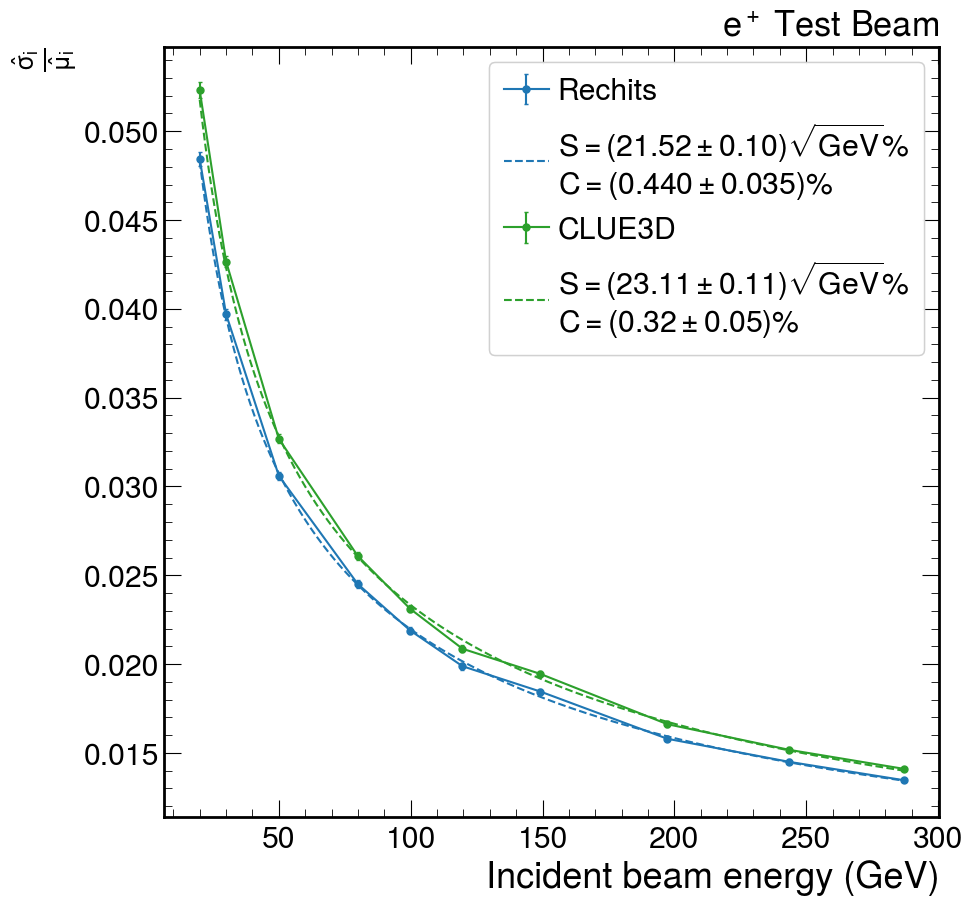

In [10]:
plotFctOfE(res_data, eRes_fit_data, showClue=False, plotFit=True)
plt.savefig("plots/sigmaOverE/fctOfE-data.pdf", bbox_inches="tight")
plotFctOfE(res_sim, eRes_fit_sim, showClue=False, sim=True, plotFit=True)
plt.savefig("plots/sigmaOverE/fctOfE-sim.pdf", bbox_inches="tight")

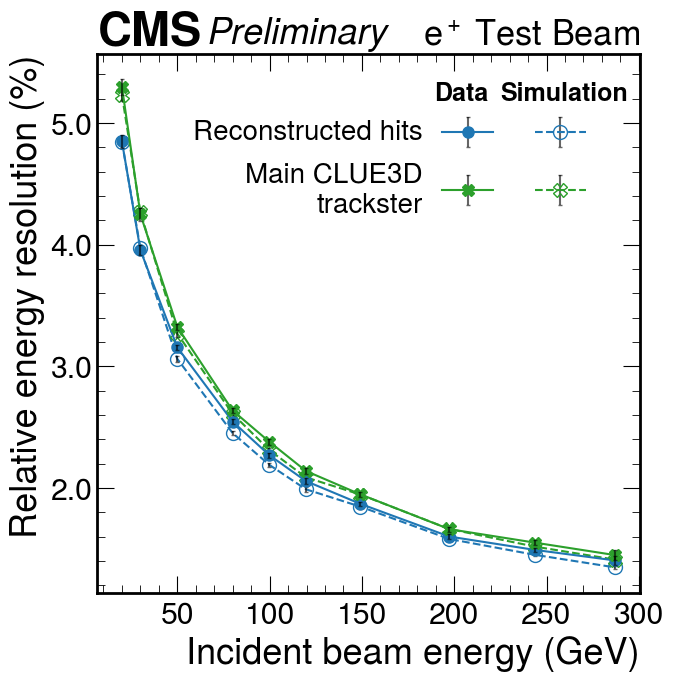

In [11]:
# Small plot for poster
plotElements = [
    SigmaOverEPlotElement("Reconstructed hits", fitResult=eRes_fit_data["rechits"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_data["rechits"]), color=levelColorMap["rechits"]),
    SigmaOverEPlotElement("Main CLUE3D trackster", fitResult=eRes_fit_data["clue3d"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_data["clue3d"]), color=levelColorMap["clue3d"]),
    SigmaOverEPlotElement("Reconstructed hits", fitResult=eRes_fit_sim["rechits"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_sim["rechits"]), color=levelColorMap["rechits"]),
    SigmaOverEPlotElement("Main CLUE3D trackster", fitResult=eRes_fit_sim["clue3d"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_sim["clue3d"]), color=levelColorMap["clue3d"]),
]
xMode = "E"
markersize = 8
errors = True
import collections
fig, ax = plt.subplots(figsize=(7, 7))
#matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
ax.set_xlabel(r"Incident beam energy (GeV)", usetex=False)
ax.set_ylabel(r"Relative energy resolution (%)", usetex=False)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, symbol=None, decimals=1))
handles = []
sim_eb_kwargs = dict(ls="--")
for i, plotElement in enumerate(plotElements):
    if plotElement.dataPoints is not None:
        xValues = np.array([synchrotronBeamEnergiesMap[beamEnergy] for beamEnergy in plotElement.dataPoints.keys()])
        if xMode == "1/sqrt(E)":
            xValues = 1/np.sqrt(xValues)
        
        yValues = np.fromiter(plotElement.dataPoints.values(), dtype=object)
        yValues_nominal = unumpy.nominal_values(yValues)

        common_kwargs = dict(marker='o' if i%2 == 0 else 'X', label=plotElement.legend, color=plotElement.color,
                             capsize=1.5, elinewidth=1.5, ecolor=matplotlib.colors.to_rgba("black", 0.6), barsabove=True)
        #if not linkPointsWithLines:
        #    common_kwargs["linestyle"] = "none"
        if i in [0, 1]: #data
            h = ax.errorbar(xValues, yValues_nominal, yerr=unumpy.std_devs(yValues),  
                    **common_kwargs, fillstyle="full",  markersize=markersize,)
        else: # simulation
            h = ax.errorbar(xValues, yValues_nominal, yerr=unumpy.std_devs(yValues),  
                    **common_kwargs, **sim_eb_kwargs, zorder=-1, fillstyle="none",  markersize=markersize+2)
            #h.plotline.set_markerface
        # if errors:
        #     h = ax.errorbar(xValues, yValues_nominal, yerr=unumpy.std_devs(yValues),  
        #             capsize=1.5, elinewidth=1.5,**common_kwargs)
        # else:
        #     h = ax.plot(xValues, yValues_nominal, **common_kwargs)[0]

        handles.append(h)
# from cmsplots import cms_exp_text
# cms_exp_text("Preliminary", loc=5, ax=ax)
hep.cms.text("Preliminary", ax=ax)
hep.cms.lumitext("$e^+$ Test Beam", ax=ax)

# handle_sim = ax.errorbar([], [], yerr=[], marker='none', markersize=markersize, fillstyle="none", 
#                              capsize=1.5, elinewidth=1.5, **sim_eb_kwargs, label="Simulation", color="grey")
# ax.legend(handles=handles[0:2]+[handle_sim], loc="upper right", bbox_to_anchor=(1, 1))

yTop = 1-0.06
legendKw = dict(
    handleheight=1.8, handlelength=1.7
    )
leg1 = ax.legend(handles=ax.get_legend_handles_labels()[0][:2], labels=[None]*2, loc="upper right", bbox_to_anchor=(0.83, yTop), **legendKw)
ax.add_artist(leg1)
ax.legend(handles=ax.get_legend_handles_labels()[0][2:], labels=[None]*2, loc="upper right", bbox_to_anchor=(1.0, yTop), **legendKw)
textKw = dict(transform=ax.transAxes, fontsize=20, ha="right", va="top")
textYTop = yTop - 0.06
ax.text(x=0.6, y=textYTop, s="Reconstructed hits", **textKw)
ax.text(x=0.6, y=textYTop-0.08, s="Main CLUE3D\ntrackster", **textKw)
ax.text(x=0.67, y=1-0.05, ha="center", va="top", fontsize=18, transform=ax.transAxes, s="Data", weight="bold")
ax.text(x=0.86, y=1-0.05, ha="center", va="top", fontsize=18, transform=ax.transAxes, s="Simulation", weight="bold")


plt.savefig("plots/sigmaOverE/fctOfE-datasim-small.pdf", bbox_inches="tight")

In [12]:
def plotFctOfSqrtE(res, eRes_fit, **kwargs):
    # fig = plt.figure()
    # grid = fig.add_gridspec(2, 1, hspace=0, height_ratios=[3, 1])
    # main_ax = fig.add_subplot(grid[0])
    # subplot_ax = fig.add_subplot(grid[1], sharex=main_ax)
    # plt.setp(main_ax.get_xticklabels(), visible=False)
    
    plotSigmaOverMean(plotElements=[
        SigmaOverEPlotElement("Rechits", fitResult=eRes_fit["rechits"], fitFunction=sigmaOverE_fitFunction, 
            dataPoints=makeDataPoints(res["rechits"]), color=levelColorMap["rechits"], legendGroup=0),
        # SigmaOverEPlotElement("CLUE", fitResult=eRes_fit["clue"], fitFunction=sigmaOverE_fitFunction, 
        #     dataPoints=makeDataPoints(res["clue"]), color=levelColorMap["clue"], legendGroup=1),
        SigmaOverEPlotElement("CLUE3D", fitResult=eRes_fit["clue3d"], fitFunction=sigmaOverE_fitFunction, 
            dataPoints=makeDataPoints(res["clue3d"]), color=levelColorMap["clue3d"], legendGroup=0),
        
    ], xMode="1/sqrt(E)", plotFit=True)
    plt.annotate(r"Fitting $\frac{\hat{\sigma}_i}{\hat{\mu}_i} = \frac{S}{\sqrt{E_i^{incident}}} \oplus C$", (0.06, 0.035))

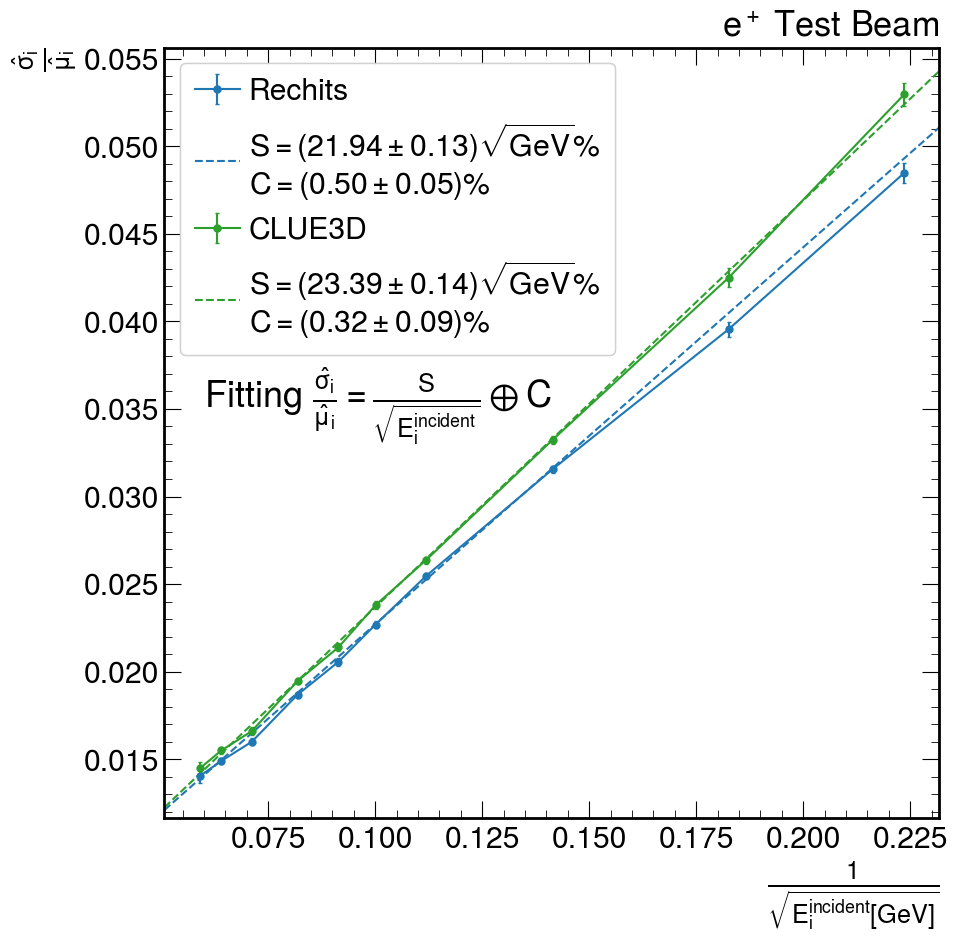

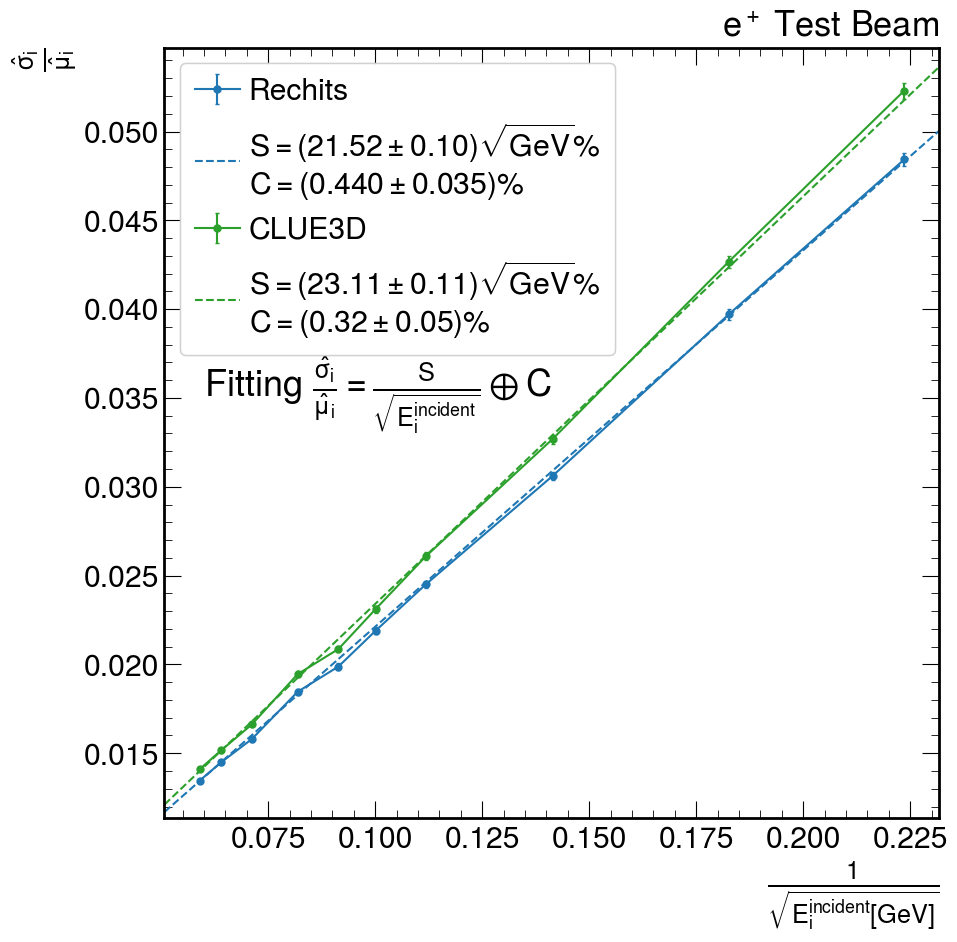

In [13]:
plotFctOfSqrtE(res_data, eRes_fit_data, xMode="1/sqrt(E)")
plt.savefig("plots/sigmaOverE/fctOfSqrtE-data.pdf", bbox_inches="tight")
plotFctOfSqrtE(res_sim, eRes_fit_sim, sim=True, xMode="1/sqrt(E)")
plt.savefig("plots/sigmaOverE/fctOfSqrtE-sim.pdf", bbox_inches="tight")

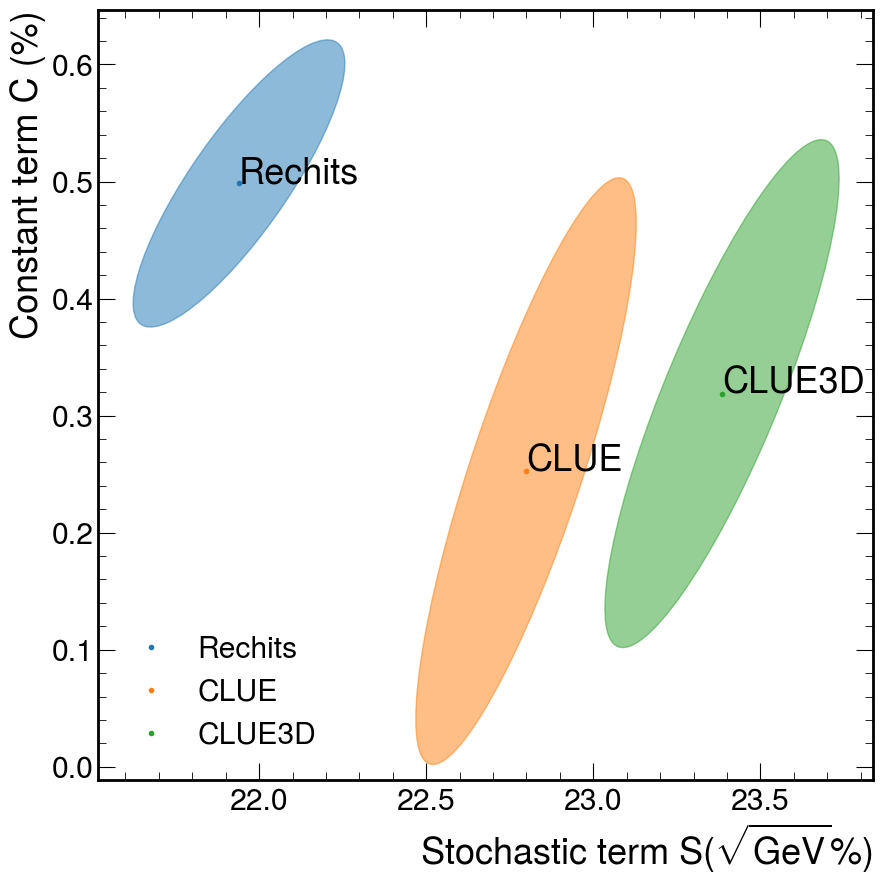

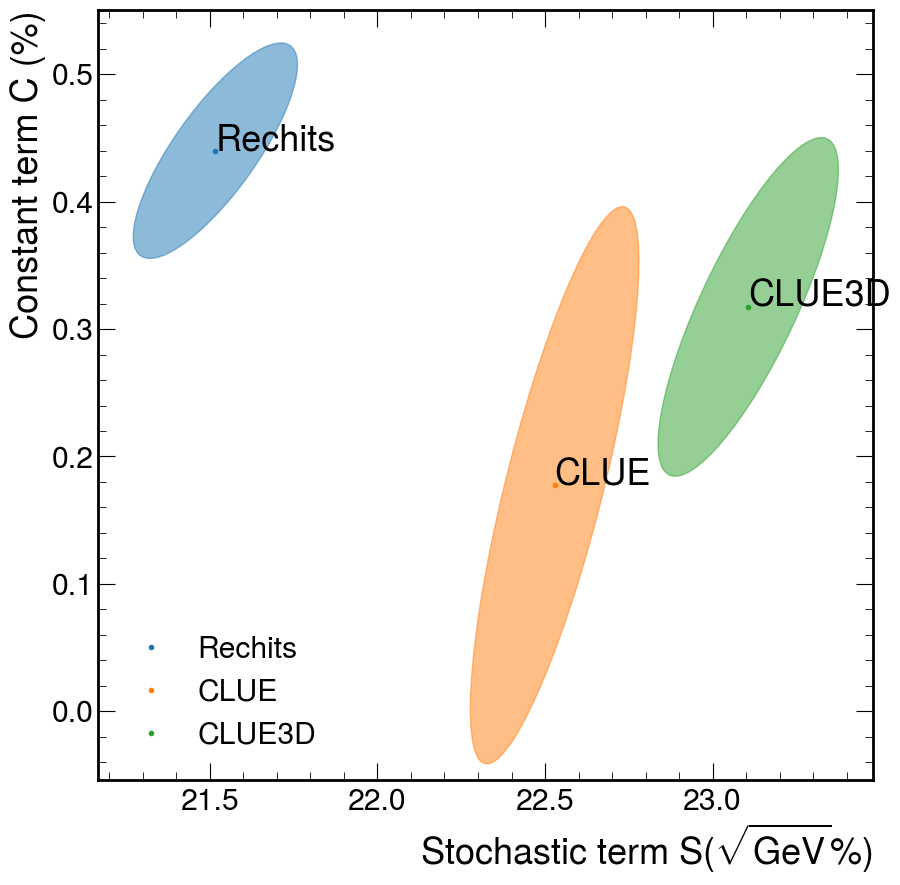

In [14]:
def plotEllipseForDatatype(res, eRes_fit, **kwargs):
    plotSCAsEllipse([
            SigmaOverEPlotElement("Rechits", fitResult=eRes_fit["rechits"], fitFunction=sigmaOverE_fitFunction, 
                dataPoints=makeDataPoints(res["rechits"]), color=levelColorMap["rechits"], legendGroup=0),
            SigmaOverEPlotElement("CLUE", fitResult=eRes_fit["clue"], fitFunction=sigmaOverE_fitFunction, 
                dataPoints=makeDataPoints(res["clue"]), color=levelColorMap["clue"], legendGroup=1),
            SigmaOverEPlotElement("CLUE3D", fitResult=eRes_fit["clue3d"], fitFunction=sigmaOverE_fitFunction, 
                dataPoints=makeDataPoints(res["clue3d"]), color=levelColorMap["clue3d"], legendGroup=0)
        ],
        detailedLabels=True
    )
plotEllipseForDatatype(res_data, eRes_fit_data)
plotEllipseForDatatype(res_sim, eRes_fit_sim)

### Ellipses for report

In [15]:
plotElts_data = [
    SigmaOverEPlotElement("Rechits (data)", fitResult=eRes_fit_data["rechits"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_data["rechits"]), color=levelColorMap["rechits"], legendGroup=0),
    SigmaOverEPlotElement("CLUE (data)", fitResult=eRes_fit_data["clue"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_data["clue"]), color=levelColorMap["clue"], legendGroup=1),
    SigmaOverEPlotElement("CLUE3D (data)", fitResult=eRes_fit_data["clue3d"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_data["clue3d"]), color=levelColorMap["clue3d"], legendGroup=0),
]
plotElts_sim = [
    SigmaOverEPlotElement("Rechits (simulation)", fitResult=eRes_fit_sim["rechits"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_sim["rechits"]), color=levelColorMap["rechits"], legendGroup=0),
    SigmaOverEPlotElement("CLUE (simulation)", fitResult=eRes_fit_sim["clue"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_sim["clue"]), color=levelColorMap["clue"], legendGroup=1),
    SigmaOverEPlotElement("CLUE3D (simulation)", fitResult=eRes_fit_sim["clue3d"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_sim["clue3d"]), color=levelColorMap["clue3d"], legendGroup=0)
]

def makeEllipsesFigure(**kwargs):
    fig, ax = plt.subplots(**kwargs)
    def plotEllipseFromPlotElts(plotElement:SigmaOverEPlotElement, sim=False, **ellipse_kwargs):
        S_scaled, C_scaled = plotElement.fitResult.S*100, plotElement.fitResult.C*100
        x, y = S_scaled.nominal_value, C_scaled.nominal_value
        label = None if sim else plotElement.legend
        ax.plot([x], [y], "+", label=label, color=plotElement.color)
        ax.add_patch(plotEllipse(S_scaled, C_scaled, ellipse_kwargs=dict(color=plotElement.color, alpha=0.5)|ellipse_kwargs))
        if not sim:
            #ax.annotate(plotElement.legend, xy=(x, y))
            pass

    legend_handle_bound = functools.partial(plt.scatter, [], [], s=500, marker='o', alpha=0.5,)
    legend_handles = []
    for plotElement_data, plotElement_sim in zip(plotElts_data, plotElts_sim):
        plotEllipseFromPlotElts(plotElement_data)
        legend_handles.append(legend_handle_bound(label=plotElement_data.legend, color=plotElement_data.color))
        plotEllipseFromPlotElts(plotElement_sim, sim=True, hatch="x", alpha=0.3, zorder=-1)
        legend_handles.append(legend_handle_bound(label=plotElement_sim.legend, color=plotElement_sim.color, alpha=0.3,  hatch="xx"))

    hep.cms.text("Preliminary", ax=ax)
    hep.cms.lumitext(f"$e^+$ Test Beam", ax=ax)
    ax.set_xlabel(r"Stochastic term $S (\sqrt{GeV} \%)$")
    ax.set_ylabel(r"Constant term C (%)")
    ax.set_xlim(left=21)
    return fig, ax

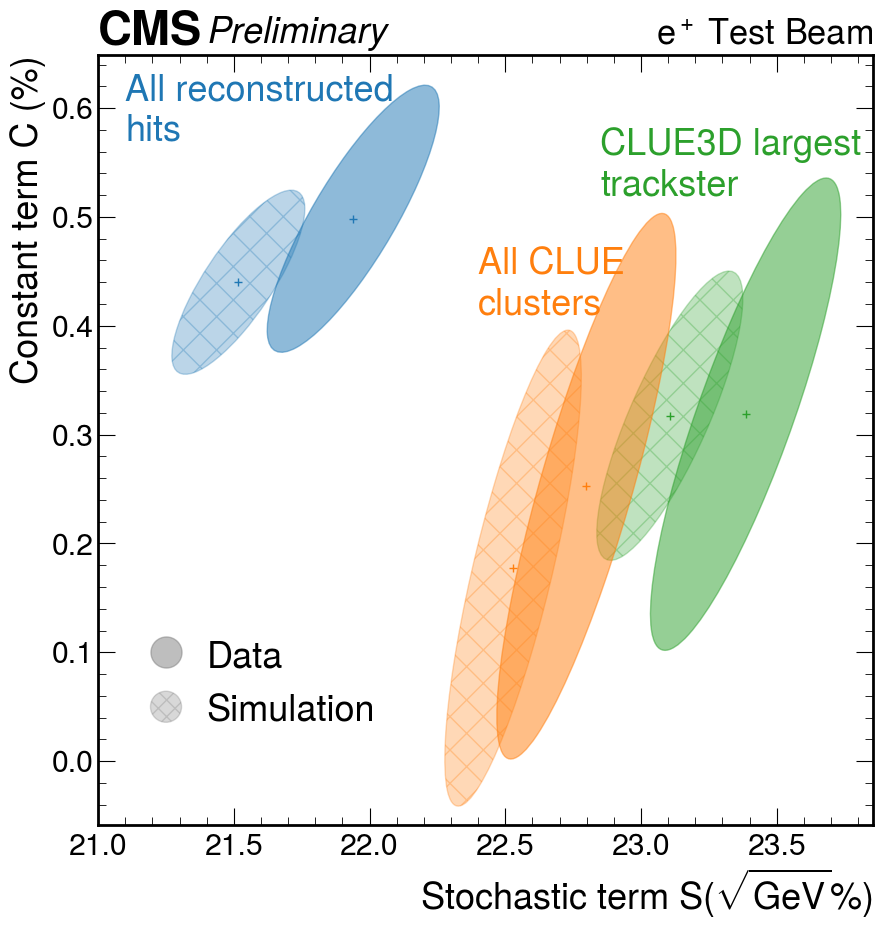

In [16]:
fig, ax = makeEllipsesFigure()
#ax.legend(handles=legend_handles, prop={'size': 19})
ax.annotate("All reconstructed\nhits", (21.1, 0.57), color="tab:blue")
ax.annotate("All CLUE\nclusters", (22.4, 0.41), color="tab:orange")
ax.annotate("CLUE3D largest\ntrackster", (22.85, 0.52), color="tab:green")

xMarkers = 21.25
ax.scatter([xMarkers], [0.1], alpha=0.5, color="tab:gray", s=500)
ax.scatter([xMarkers], [0.05], alpha=0.3,hatch="xx", color="tab:gray", s=500)
xLegend = 21.4
padLegend = -0.005
ax.annotate("Data", (xLegend, 0.1+padLegend), ha="left", va="center")
ax.annotate("Simulation", (xLegend, 0.05+padLegend), ha="left", va="center")
#plt.savefig("plots/energy-resolution-ellipses.png", bbox_inches="tight", dpi=200) 
plt.savefig("plots/energy-resolution-ellipses.pdf", bbox_inches="tight") # for some reasons hatches don't work in some pdf readers

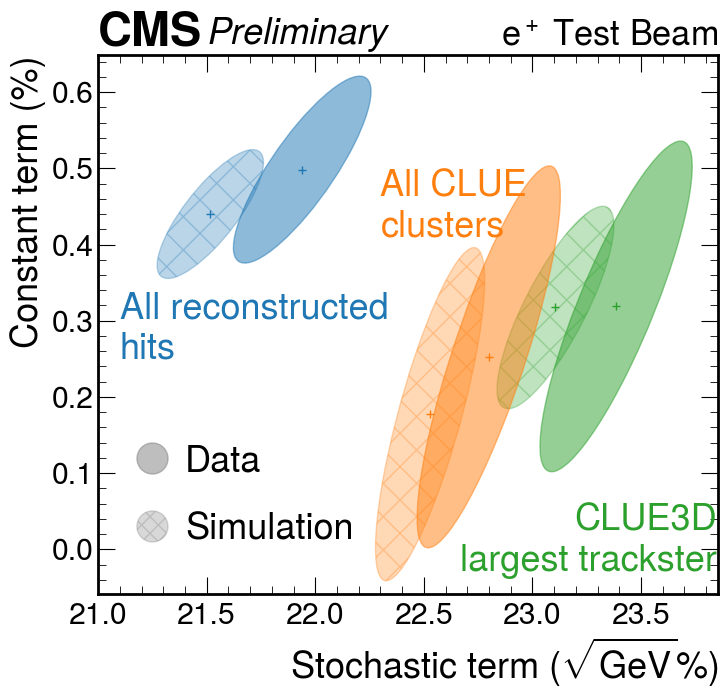

In [17]:
# small version
fig, ax = makeEllipsesFigure(figsize=(8, 7))
ax.set_xlabel(r"Stochastic term $(\sqrt{GeV} \%)$")
ax.set_ylabel(r"Constant term (%)")
#ax.legend(handles=legend_handles, prop{'size': 19})
ax.annotate("All reconstructed\nhits", (21.1, 0.25), color="tab:blue")
ax.annotate("All CLUE\nclusters", (22.3, 0.41), color="tab:orange")
ax.annotate("CLUE3D\nlargest trackster", (23.85, 0.06), color="tab:green", ha="right", va="top")
xMarkers = 21.25
ax.scatter([xMarkers], [0.12], alpha=0.5, color="tab:gray", s=500)
ax.scatter([xMarkers], [0.03], alpha=0.3,hatch="xx", color="tab:gray", s=500)
xLegend = 21.4
padLegend = -0.005
ax.annotate("Data", (xLegend, 0.12+padLegend), ha="left", va="center")
ax.annotate("Simulation", (xLegend, 0.03+padLegend), ha="left", va="center")

plt.savefig("plots/energy-resolution-ellipses-small.pdf", bbox_inches="tight") # for some reasons hatches don't work in some pdf readers

### Ellipses for DPG

Text(22.1, 0.72, 'JINST paper')

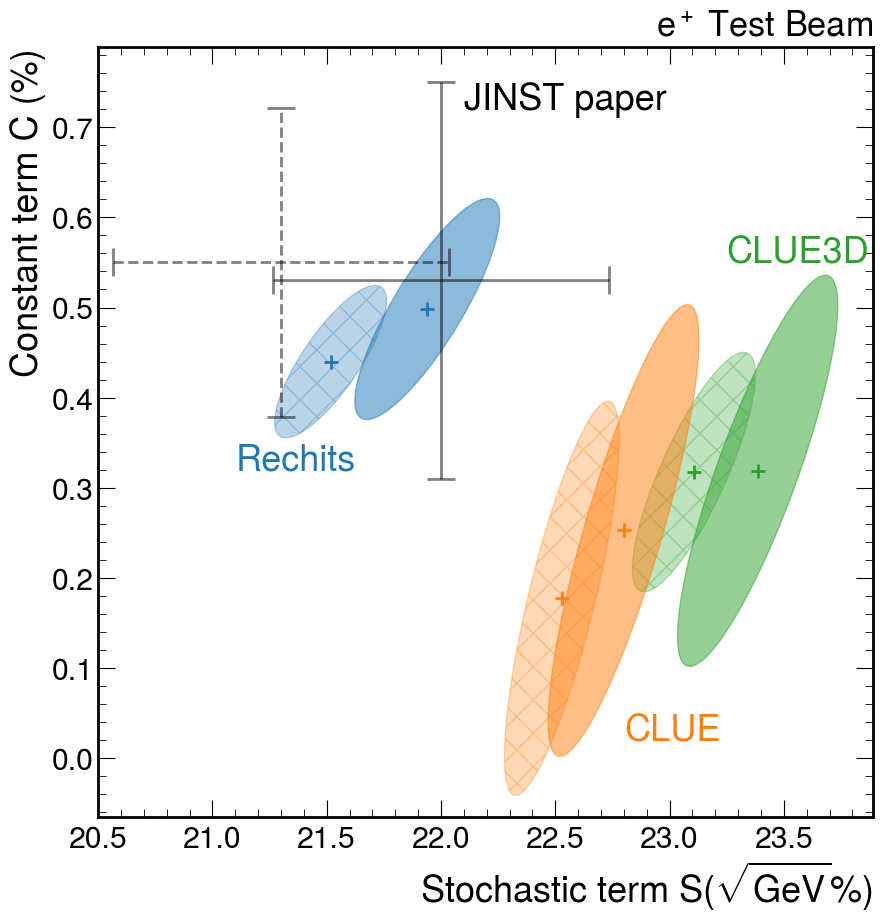

In [18]:
plotElts_data = [
    SigmaOverEPlotElement("Rechits (data)", fitResult=eRes_fit_data["rechits"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_data["rechits"]), color=levelColorMap["rechits"], legendGroup=0),
    SigmaOverEPlotElement("CLUE (data)", fitResult=eRes_fit_data["clue"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_data["clue"]), color=levelColorMap["clue"], legendGroup=1),
    SigmaOverEPlotElement("CLUE3D (data)", fitResult=eRes_fit_data["clue3d"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_data["clue3d"]), color=levelColorMap["clue3d"], legendGroup=0),
    #SigmaOverEPlotElement("JINST paper (data)", fitResult=paperResolution_data, color=levelColorMap["paper"], legendGroup=1),
]
plotElts_sim = [
    SigmaOverEPlotElement("Rechits (simulation)", fitResult=eRes_fit_sim["rechits"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_sim["rechits"]), color=levelColorMap["rechits"], legendGroup=0),
    SigmaOverEPlotElement("CLUE (simulation)", fitResult=eRes_fit_sim["clue"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_sim["clue"]), color=levelColorMap["clue"], legendGroup=1),
    SigmaOverEPlotElement("CLUE3D (simulation)", fitResult=eRes_fit_sim["clue3d"], fitFunction=sigmaOverE_fitFunction, 
        dataPoints=makeDataPoints(res_sim["clue3d"]), color=levelColorMap["clue3d"], legendGroup=0),
    #SigmaOverEPlotElement("JINST paper (simulation)", fitResult=paperResolution_sim, color=levelColorMap["paper"], legendGroup=1),
]
fig, ax = plt.subplots()
def plotEllipseFromPlotElts(plotElement:SigmaOverEPlotElement, sim=False, **ellipse_kwargs):
    S_scaled, C_scaled = plotElement.fitResult.S*100, plotElement.fitResult.C*100
    x, y = S_scaled.nominal_value, C_scaled.nominal_value
    label = None if sim else plotElement.legend
    ax.plot([x], [y], "+", label=label, color=plotElement.color, markersize=10, mew=2)
    ax.add_patch(plotEllipse(S_scaled, C_scaled, ellipse_kwargs=dict(color=plotElement.color, alpha=0.5)|ellipse_kwargs))
    if not sim:
        #ax.annotate(plotElement.legend, xy=(x, y))
        pass

s_sqrt = math.sqrt(scipy.stats.chi2.isf(1-0.95, 2))
common_kwargs = dict(ecolor="black", elinewidth=2, capsize=10, capthick=2, alpha=0.5)
eb_data=ax.errorbar(x=[paperResolution_data.S.nominal_value*100], y=[paperResolution_data.C.nominal_value*100], 
            xerr=[(paperResolution_data.S*100).std_dev*s_sqrt], yerr=[(paperResolution_data.C*100).std_dev*s_sqrt],
            **common_kwargs)
eb_sim=ax.errorbar(x=[paperResolution_sim.S.nominal_value*100], y=[paperResolution_sim.C.nominal_value*100], 
            xerr=[(paperResolution_sim.S*100).std_dev*s_sqrt], yerr=[(paperResolution_sim.C*100).std_dev*s_sqrt],
            **common_kwargs)
for line in eb_sim[-1]:
    line.set_linestyle("--")

legend_handle_bound = functools.partial(plt.scatter, [], [], s=500, marker='o', alpha=0.5,)
legend_handles = []
for plotElement_data, plotElement_sim in zip(plotElts_data, plotElts_sim):
    plotEllipseFromPlotElts(plotElement_data)
    legend_handles.append(legend_handle_bound(label=plotElement_data.legend, color=plotElement_data.color))
    plotEllipseFromPlotElts(plotElement_sim, sim=True, hatch="x", alpha=0.3, zorder=-1)
    legend_handles.append(legend_handle_bound(label=plotElement_sim.legend, color=plotElement_sim.color, alpha=0.3,  hatch="xx"))

#hep.cms.text("Preliminary", ax=ax)
hep.cms.lumitext(f"$e^+$ Test Beam", ax=ax)
ax.set_xlabel(r"Stochastic term $S (\sqrt{GeV} \%)$")
ax.set_ylabel(r"Constant term C (%)")
ax.set_xlim(left=20.5)

#ax.legend(handles=legend_handles, prop={'size': 19})
ax.annotate("Rechits", (21.1, 0.32), color="tab:blue")
ax.annotate("CLUE", (22.8, 0.02), color="tab:orange")
ax.annotate("CLUE3D", (23.25, 0.55), color="tab:green")
ax.annotate("JINST paper", (22.1, 0.72), color="black")


#plt.savefig("plots/energy-resolution-ellipses.png", bbox_inches="tight", dpi=200) # for some reasons hatches don't work in pdf

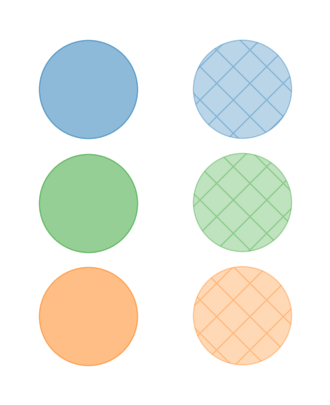

In [19]:
# Legend
plt.figure(figsize=(4, 5))
kwargs = dict(s=5000, marker='o',)
plt.scatter([0], [2], **kwargs, alpha=0.5, color="tab:blue")
plt.scatter([1], [2], **kwargs, alpha=0.3,hatch="x", color="tab:blue")
plt.scatter([0], [1], **kwargs, alpha=0.5, color="tab:green")
plt.scatter([1], [1], **kwargs, alpha=0.3,hatch="x", color="tab:green")
plt.scatter([0], [0], **kwargs, alpha=0.5, color="tab:orange")
plt.scatter([1], [0], **kwargs, alpha=0.3,hatch="x", color="tab:orange")
plt.xlim(-0.5, 1.5)
plt.ylim(-0.7, 2.7)
plt.axis("off")
plt.savefig("plots/ellipses-legend.pdf", bbox_inches="tight") 

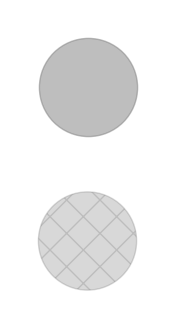

In [20]:
# Legend
plt.figure(figsize=(2, 4))
kwargs = dict(s=5000, marker='o',)
plt.scatter([0], [1], **kwargs, alpha=0.5, color="tab:gray")
plt.scatter([0], [0], **kwargs, alpha=0.3,hatch="x", color="tab:gray")
plt.ylim(-0.5, 1.5)
plt.axis("off")
plt.savefig("plots/ellipses-legend-single.pdf", bbox_inches="tight") 